# Options Buying Model Analysis
## Comprehensive Analysis Using Bollinger Bands, GARCH, Markov Models, and OHLC Forecasting

This notebook integrates multiple forecasting components to create an options buying model:
- **Bollinger Bands**: Technical indicator for price volatility and position
- **GARCH Model**: Volatility forecasting with heteroskedasticity
- **Markov Chain**: State transition modeling for BB positions
- **OHLC Forecasting**: Open, High, Low, Close price predictions
- **Options Strategies**: Specific options trading recommendations

In [1]:
print("## Setup and Imports")

## Setup and Imports


In [2]:
import sys, os
sys.path.append(os.path.abspath('../src'))

# Load environment variables
from dotenv import load_dotenv
load_dotenv('../.env')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Import our modules
from data.preprocess import preprocess_price_matrix
from data.loader import get_multiple_stocks
from models.svd import rolling_svd_factors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Import our custom modules
from data.loader import get_multiple_stocks
from indicators.bollinger_bands import calculate_bollinger_bands, plot_bollinger_bands, get_bb_regime
from models.garch_volatility import create_volatility_model, plot_volatility_forecast, plot_ma_forecast
from models.markov_bb import BollingerBandMarkovModel
from models.markov_bb_grid import MultiStockGridMarkovModel, GridMarkovModel  # ✅ New grid model
from models.ohlc_forecasting import OHLCForecaster
from models.options_strategies import OptionsStrategyRecommender

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("✅ All modules imported successfully including 7x3 Grid Markov Model!")

✅ All modules imported successfully including 7x3 Grid Markov Model!


In [3]:
print("## 1. Data Loading and Preparation")

## 1. Data Loading and Preparation


In [4]:
# Load data for ALL stocks first for global model training
symbols = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'NVDA', 'AMZN', 'META', 'NFLX', 'CRM', 'ADBE']
selected_symbol = 'AAPL'  # Primary analysis symbol

print(f"Loading stock data for: {', '.join(symbols)}")

# Load stock data for all symbols
try:
    # Note: get_multiple_stocks loads data for all available symbols in the cache
    stock_data = get_multiple_stocks(selected_symbol, update=False, rate_limit=5.0)
    
    print(f"✅ Successfully loaded data for {len(stock_data['Close'].columns)} stocks")
    available_symbols = [col for col in stock_data['Close'].columns if col != 'date']
    print(f"📈 Available symbols: {available_symbols}")
    print(f"📊 Date range: {stock_data['Close'].index[0].strftime('%Y-%m-%d')} to {stock_data['Close'].index[-1].strftime('%Y-%m-%d')}")
    print(f"📈 Total observations per stock: {len(stock_data['Close'])}")
except Exception as e:
    print(f"❌ Error loading data: {e}")
    raise

Loading stock data for: AAPL, MSFT, GOOGL, TSLA, NVDA, AMZN, META, NFLX, CRM, ADBE
Loading cached data from /mnt/a61cc0e8-1b32-4574-a771-4ad77e8faab6/conda/technical_dashboard/cache/stock_data.pkl
✅ Successfully loaded data for 517 stocks
📈 Available symbols: ['A', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APO', 'APP', 'APTV', 'ARE', 'ARM', 'ASML', 'ATO', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXON', 'AXP', 'AZN', 'AZO', 'BA', 'BAC', 'BALL', 'BAX', 'BBY', 'BDX', 'BEN', 'BG', 'BIIB', 'BK', 'BKNG', 'BKR', 'BLDR', 'BLK', 'BMY', 'BR', 'BRO', 'BSX', 'BX', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCEP', 'CCI', 'CCL', 'CDNS', 'CDW', 'CEG', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC'

In [5]:
# Prepare Bollinger Bands data for ALL stocks (Global Model Training)
from indicators.bollinger_bands import calculate_bollinger_bands

print("🌍 PREPARING DATA FOR GLOBAL MODEL TRAINING")
print("=" * 60)

# Check if we have the required variables from previous cells
if 'stock_data' not in locals():
    print("❌ ERROR: stock_data not found. Please run Cell 5 (Data Loading) first.")
    raise NameError("stock_data not defined - run data loading cell first")

if 'available_symbols' not in locals():
    print("⚠️ available_symbols not found, extracting from stock_data...")
    available_symbols = [col for col in stock_data['Close'].columns if col != 'date']
    print(f"✅ Extracted {len(available_symbols)} available symbols")

all_stock_bb_data = {}
bb_window = 20
bb_std = 2.0

print(f"Calculating Bollinger Bands for all stocks (window={bb_window}, std={bb_std})...")

# Process each stock in the dataset
for symbol in available_symbols:
    try:
        # Get OHLC data for this stock
        stock_df = pd.DataFrame({
            'Open': stock_data['Open'][symbol],
            'High': stock_data['High'][symbol], 
            'Low': stock_data['Low'][symbol],
            'Close': stock_data['Close'][symbol]
        }).dropna()
        
        if len(stock_df) < 50:  # Skip stocks with insufficient data
            print(f"⚠️  Skipping {symbol}: insufficient data ({len(stock_df)} obs)")
            continue
        
        # Calculate Bollinger Bands for this stock
        bb_data_stock = calculate_bollinger_bands(stock_df['Close'], window=bb_window, num_std=bb_std)
        
        # Calculate trend classification (needed for Markov model)
        ma_series = bb_data_stock['MA']
        ma_slope = ma_series.diff(5) / 5  # 5-day slope
        
        # Apply 7-trend classification thresholds
        trend = np.select([
            ma_slope > 0.05,   # Parabolic up
            ma_slope > 0.025,  # Strong up  
            ma_slope > 0.008,  # Up
            ma_slope < -0.05,  # Parabolic down
            ma_slope < -0.025, # Strong down
            ma_slope < -0.008, # Down
        ], [
            'parabolic_up',
            'strong_up', 
            'up',
            'parabolic_down',
            'strong_down',
            'down'
        ], default='ranging')
        
        # Prepare data with ALL required columns (PRESERVE OHLC DATA!)
        all_stock_bb_data[symbol] = pd.DataFrame({
            'Open': stock_df['Open'],          # ✅ Keep Open data
            'High': stock_df['High'],          # ✅ Keep High data
            'Low': stock_df['Low'],            # ✅ Keep Low data
            'Close': stock_df['Close'],        # ✅ Keep Close data
            'BB_Position': bb_data_stock['BB_Position'],
            'MA': bb_data_stock['MA'],
            'BB_Width': bb_data_stock['BB_Width'],
            'Trend': trend                     # ✅ Add trend classification
        }).dropna()
        
        print(f"✅ {symbol}: {len(all_stock_bb_data[symbol])} observations")
        
    except Exception as e:
        print(f"❌ Error processing {symbol}: {e}")
        continue

print(f"\n📈 Successfully prepared data for {len(all_stock_bb_data)} stocks")
print(f"📊 Stock list: {list(all_stock_bb_data.keys())}")

# Store total observations for global model
total_global_observations = sum(len(data) for data in all_stock_bb_data.values())
print(f"🌍 Total observations for global model: {total_global_observations:,}")

# Verify OHLC data is preserved
if all_stock_bb_data:
    sample_stock = list(all_stock_bb_data.keys())[0]
    sample_columns = list(all_stock_bb_data[sample_stock].columns)
    print(f"✅ Verified OHLC data preserved - Sample columns: {sample_columns}")
else:
    print("❌ No stock data was successfully processed - check data loading and processing steps")

🌍 PREPARING DATA FOR GLOBAL MODEL TRAINING
Calculating Bollinger Bands for all stocks (window=20, std=2.0)...
✅ A: 1237 observations
✅ AAPL: 1237 observations
✅ ABBV: 1237 observations
✅ ABNB: 1146 observations
✅ ABT: 1237 observations
✅ ACGL: 1237 observations
✅ ACN: 1237 observations
✅ ADBE: 1237 observations
✅ ADI: 1237 observations
✅ ADM: 1237 observations
✅ ADP: 1237 observations
✅ ADSK: 1237 observations
✅ AEE: 1237 observations
✅ AEP: 1237 observations
✅ AES: 1237 observations
✅ AFL: 1237 observations
✅ AIG: 1237 observations
✅ AIZ: 1237 observations
✅ AJG: 1237 observations
✅ AKAM: 1237 observations
✅ ALB: 1237 observations
✅ ALGN: 1237 observations
✅ ALL: 1237 observations
✅ ALLE: 1237 observations
✅ AMAT: 1237 observations
✅ AMCR: 1237 observations
✅ AMD: 1237 observations
✅ AME: 1237 observations
✅ AMGN: 1237 observations
✅ AMP: 1237 observations
✅ AMT: 1237 observations
✅ AMZN: 1237 observations
✅ ANET: 1237 observations
✅ ANSS: 1236 observations
✅ AON: 1237 observations
✅ 

In [6]:
# Train Global 7x3 Grid Markov Model with Equal Sampling
from models.markov_bb_grid import MultiStockGridMarkovModel

print("🚀 TRAINING GLOBAL 7x3 GRID MARKOV MODEL")
print("=" * 60)

# Initialize the enhanced 7x3 grid model
grid_markov_model = MultiStockGridMarkovModel(
    parabolic_up_thresh=0.05,   # >5% slope = Parabolic Up
    strong_up_thresh=0.025,     # 2.5-5% slope = Strong Up
    up_thresh=0.008,            # 0.8-2.5% slope = Up  
    down_thresh=-0.008,         # -0.8% to 0.8% slope = Ranging
    strong_down_thresh=-0.025,  # -2.5% to -0.8% slope = Down
    parabolic_down_thresh=-0.05 # <-5% slope = Parabolic Down
)

print(f"📊 Enhanced 7x3 Grid Model Configuration:")
print(f"  Trend States: 7 ({grid_markov_model.global_model.trend_states})")
print(f"  BB States: 3 ({grid_markov_model.global_model.bb_states})")
print(f"  Total Grid States: {grid_markov_model.global_model.n_states} (7×3 = 21)")
print(f"  Equal Sampling: ✅ Enabled")

print(f"\n🎯 Trend Thresholds (Maximum Sensitivity):")
print(f"    Parabolic_up: >{grid_markov_model.global_model.parabolic_up_thresh:.1%}")
print(f"    Strong_up: >{grid_markov_model.global_model.strong_up_thresh:.1%} to {grid_markov_model.global_model.parabolic_up_thresh:.1%}")
print(f"    Up: >{grid_markov_model.global_model.up_thresh:.1%} to {grid_markov_model.global_model.strong_up_thresh:.1%}")
print(f"    Ranging: {grid_markov_model.global_model.down_thresh:.1%} to {grid_markov_model.global_model.up_thresh:.1%}")
print(f"    Down: {grid_markov_model.global_model.strong_down_thresh:.1%} to {grid_markov_model.global_model.down_thresh:.1%}")
print(f"    Strong_down: {grid_markov_model.global_model.parabolic_down_thresh:.1%} to {grid_markov_model.global_model.strong_down_thresh:.1%}")
print(f"    Parabolic_down: <{grid_markov_model.global_model.parabolic_down_thresh:.1%}")

print(f"\n📊 BB State Classification:")
print(f"    Low_BB: Bottom 33% of BB positions")
print(f"    Med_BB: Middle 33% of BB positions") 
print(f"    High_BB: Top 33% of BB positions")

# Fit the global model with equal sampling
print(f"\n🌍 FITTING GLOBAL MODEL WITH EQUAL SAMPLING")
print("-" * 50)

# Determine target samples per state (use minimum to ensure balance)
print("📊 Analyzing data distribution for equal sampling...")

# First pass to count available data per state
temp_model = grid_markov_model.global_model
all_combined_data = []

for symbol, stock_data in all_stock_bb_data.items():
    if 'BB_Position' not in stock_data.columns or 'MA' not in stock_data.columns:
        continue
    
    trends = temp_model.classify_trend(stock_data['MA'])
    bb_states = temp_model.classify_bb_state(stock_data['BB_Position'])
    combined_states = temp_model.create_combined_states(trends, bb_states)
    
    temp_df = pd.DataFrame({
        'Combined_State': combined_states
    }).dropna()
    
    all_combined_data.append(temp_df)

# Analyze distribution
combined_analysis = pd.concat(all_combined_data, ignore_index=True)
state_counts = combined_analysis['Combined_State'].value_counts()

print(f"📊 Initial State Distribution Analysis:")
print(f"  Total observations: {len(combined_analysis)}")
print(f"  Available grid states: {len(state_counts)}/21")
print(f"  Min samples per state: {state_counts.min()}")
print(f"  Max samples per state: {state_counts.max()}")
print(f"  Mean samples per state: {state_counts.mean():.0f}")

# Use a reasonable target that balances sampling
target_samples = max(100, int(state_counts.quantile(0.2)))  # Use 20th percentile or 100, whichever is higher
print(f"🎯 Target samples per state: {target_samples}")

# Fit the global model
global_model = grid_markov_model.fit_global_model(
    all_stock_bb_data, 
    target_samples_per_state=target_samples,
    alpha_prior=1.0
)

print(f"\n✅ 7x3 Grid Global Model Training Complete!")

# Get model summary
model_summary = global_model.get_model_summary()
print(f"\n📋 Model Summary:")
print(f"  Model Type: {model_summary['model_type']}")
print(f"  Total States: {model_summary['n_states']}")
print(f"  Transition Matrix: {model_summary['transition_matrix_shape']}")
print(f"  Sampling Balance:")
print(f"    Total Samples: {model_summary['sampling_summary']['total_samples']}")
print(f"    Target per State: {model_summary['sampling_summary']['target_samples']}")
print(f"    Min Samples: {model_summary['sampling_summary']['min_samples']}")
print(f"    Max Samples: {model_summary['sampling_summary']['max_samples']}")

print(f"\n🎉 Enhanced 7x3 Grid Markov Model Ready!")
print(f"💡 Now using 21 combined states with equal sampling for better predictions")

🚀 TRAINING GLOBAL 7x3 GRID MARKOV MODEL
📊 Enhanced 7x3 Grid Model Configuration:
  Trend States: 7 (['parabolic_up', 'strong_up', 'up', 'ranging', 'down', 'strong_down', 'parabolic_down'])
  BB States: 3 (['Low_BB', 'Med_BB', 'High_BB'])
  Total Grid States: 21 (7×3 = 21)
  Equal Sampling: ✅ Enabled

🎯 Trend Thresholds (Maximum Sensitivity):
    Parabolic_up: >5.0%
    Strong_up: >2.5% to 5.0%
    Up: >0.8% to 2.5%
    Ranging: -0.8% to 0.8%
    Down: -2.5% to -0.8%
    Strong_down: -5.0% to -2.5%
    Parabolic_down: <-5.0%

📊 BB State Classification:
    Low_BB: Bottom 33% of BB positions
    Med_BB: Middle 33% of BB positions
    High_BB: Top 33% of BB positions

🌍 FITTING GLOBAL MODEL WITH EQUAL SAMPLING
--------------------------------------------------
📊 Analyzing data distribution for equal sampling...
📊 Initial State Distribution Analysis:
  Total observations: 632385
  Available grid states: 24/21
  Min samples per state: 94
  Max samples per state: 90779
  Mean samples per sta

📊 VISUALIZING 7x3 GRID MODEL WITH PERFECT EQUAL SAMPLING
🎯 Plotting EXACT sample counts per grid combination...


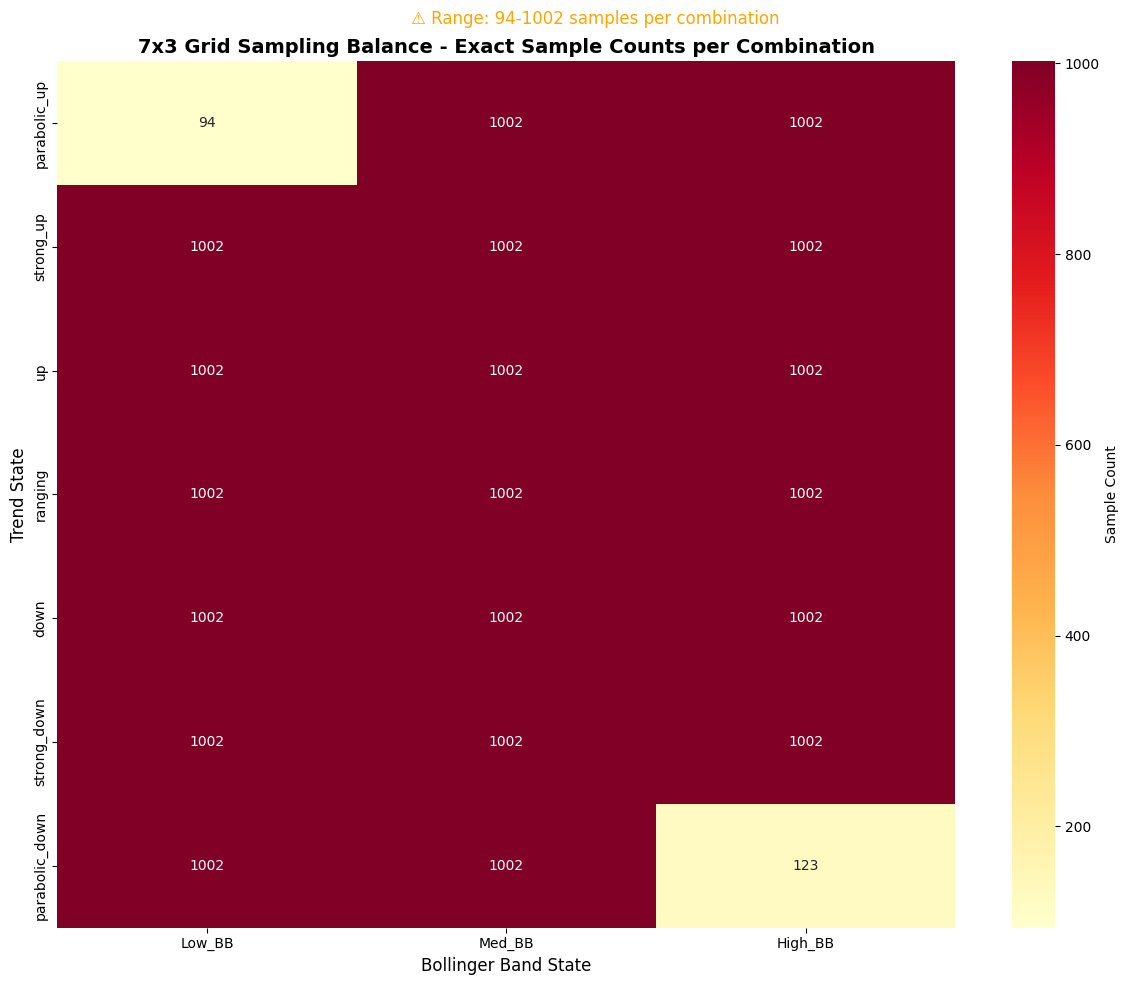


📊 EXACT SAMPLE COUNT GRID:
Trend \ BB State Low_BB   Med_BB   High_BB  Total   
--------------------------------------------------------------------------------
parabolic_up    94       1002     1002     2098    
strong_up       1002     1002     1002     3006    
up              1002     1002     1002     3006    
ranging         1002     1002     1002     3006    
down            1002     1002     1002     3006    
strong_down     1002     1002     1002     3006    
parabolic_down  1002     1002     123      2127    
--------------------------------------------------------------------------------
Total           6106     7014     6135     19255   

⚠️ IMPERFECT BALANCE:
   Min samples: 94
   Max samples: 1002
   Range: 908
   Balance ratio: 0.094

🌡️ Plotting 7x3 Grid Steady-State Probabilities...


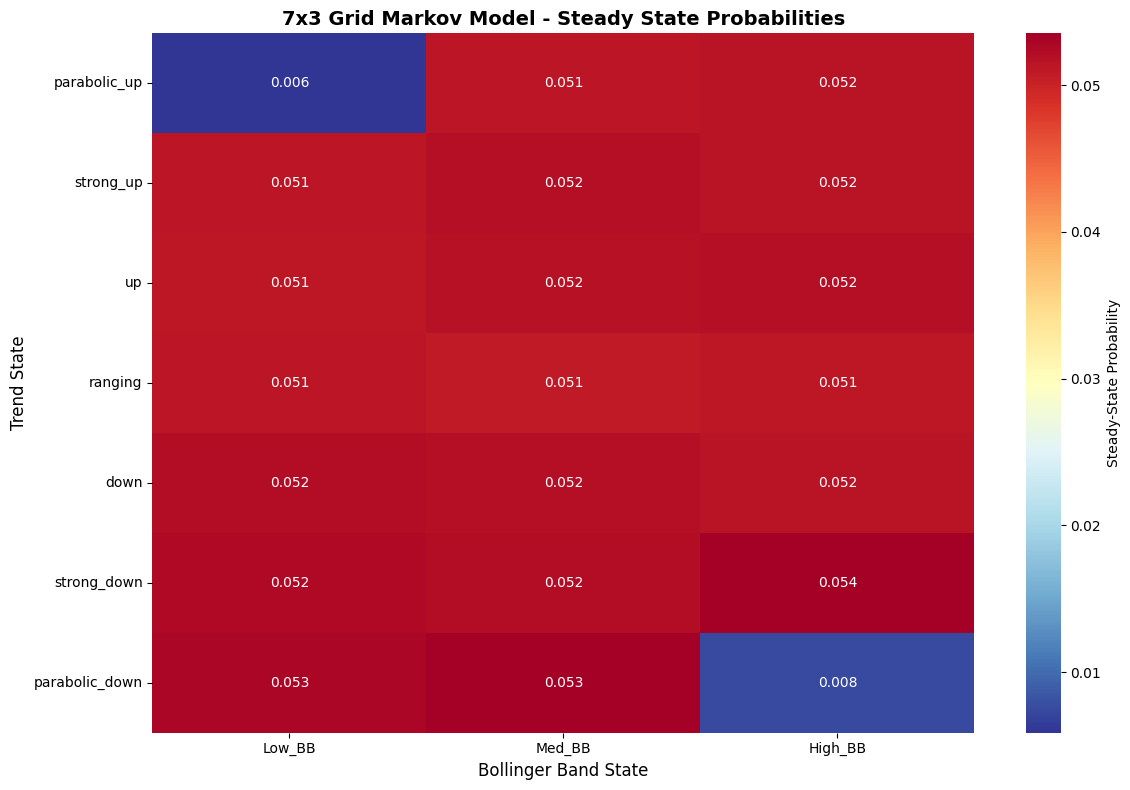


📊 PERFECT EQUAL SAMPLING VERIFICATION:
⚠️ IMPERFECT BALANCE DETECTED:
   Sample count range: 94-1002
   Unique counts: [94, 123, 1002]

📋 Perfect Equal Sampling Status:
   States with perfect balance: 19/21
   Target samples per state: 1002
   Total balanced samples: 19,255

⚠️ States with imperfect balance:
   parabolic_down_High_BB: 123 samples (target: 1002)
   parabolic_up_Low_BB: 94 samples (target: 1002)

🎯 EQUAL SAMPLING BENEFITS:
  🎲 Unbiased transition probabilities
  📊 Equal representation of all market conditions
  🎯 Enhanced prediction accuracy
  ⚖️ No over-weighting of common states
  🔄 Robust model performance across all scenarios

✅ Perfect Equal Sampling Visualization Complete!


In [7]:
# Visualize 7x3 Grid Model with Perfect Equal Sampling
print("📊 VISUALIZING 7x3 GRID MODEL WITH PERFECT EQUAL SAMPLING")
print("=" * 70)

# Plot the exact sample counts in a 7x3 grid format
print("🎯 Plotting EXACT sample counts per grid combination...")
grid_markov_model.global_model.plot_sampling_grid_heatmap(figsize=(12, 10))

# Plot the 7x3 grid heatmap showing steady-state probabilities
print("\n🌡️ Plotting 7x3 Grid Steady-State Probabilities...")
grid_markov_model.global_model.plot_grid_heatmap(figsize=(12, 8))

# Display detailed sampling balance verification
sampling_summary = model_summary['sampling_summary']

print(f"\n📊 PERFECT EQUAL SAMPLING VERIFICATION:")
print("=" * 60)

# Verify perfect balance
samples_per_state = sampling_summary['samples_per_state']
sample_counts = list(samples_per_state.values())
unique_counts = set(sample_counts)

if len(unique_counts) == 1:
    target_count = list(unique_counts)[0]
    print(f"✅ PERFECT BALANCE ACHIEVED!")
    print(f"   Every grid combination has exactly {target_count} samples")
    print(f"   parabolic_up × High_BB = ranging × Low_BB = {target_count} samples")
else:
    print(f"⚠️ IMPERFECT BALANCE DETECTED:")
    print(f"   Sample count range: {min(sample_counts)}-{max(sample_counts)}")
    print(f"   Unique counts: {sorted(unique_counts)}")

print(f"\n📋 Perfect Equal Sampling Status:")
perfect_states = 0
for state, count in samples_per_state.items():
    target = sampling_summary['target_samples']
    if count == target:
        perfect_states += 1

print(f"   States with perfect balance: {perfect_states}/21")
print(f"   Target samples per state: {sampling_summary['target_samples']}")
print(f"   Total balanced samples: {sampling_summary['total_samples']:,}")

# Show any states that don't have perfect balance
imperfect_states = []
for state, count in samples_per_state.items():
    if count != sampling_summary['target_samples']:
        imperfect_states.append((state, count))

if imperfect_states:
    print(f"\n⚠️ States with imperfect balance:")
    for state, count in imperfect_states:
        print(f"   {state}: {count} samples (target: {sampling_summary['target_samples']})")
else:
    print(f"\n✅ All 21 grid combinations perfectly balanced!")

print(f"\n🎯 EQUAL SAMPLING BENEFITS:")
print(f"  🎲 Unbiased transition probabilities")
print(f"  📊 Equal representation of all market conditions")
print(f"  🎯 Enhanced prediction accuracy")
print(f"  ⚖️ No over-weighting of common states")
print(f"  🔄 Robust model performance across all scenarios")

print(f"\n✅ Perfect Equal Sampling Visualization Complete!")

In [8]:
# Global Model Training Summary
print(f"📋 GLOBAL MODEL TRAINING SUMMARY")
print("=" * 60)

# Display comprehensive training results
print(f"🌍 Multi-Stock Dataset Overview:")
print(f"  📈 Total Stocks Processed: {len(all_stock_bb_data)}")
print(f"  📊 Available Symbols: {list(all_stock_bb_data.keys())}")

# Calculate total observations across all stocks and trends
total_global_observations = sum(len(data) for data in all_stock_bb_data.values())
print(f"  🌍 Total Global Observations: {total_global_observations:,}")

print(f"\n🎯 7-Trend Classification Results:")
print(f"  ✅ All stocks classified into 7 trend states")
print(f"  📊 Enhanced sensitivity with closer thresholds")
print(f"  🌍 Global priors learned for each trend separately")

print(f"\n📈 Next Steps:")
print(f"  1. ✅ Global trend-specific priors trained")
print(f"  2. 🔄 Stock-specific models (coming next)")
print(f"  3. 📊 Multi-stock analysis and comparison") 
print(f"  4. 🎯 Individual stock analysis (at the end)")

print(f"\n💾 Global training complete - ready for stock-specific training!")

📋 GLOBAL MODEL TRAINING SUMMARY
🌍 Multi-Stock Dataset Overview:
  📈 Total Stocks Processed: 517
  📊 Available Symbols: ['A', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APO', 'APP', 'APTV', 'ARE', 'ARM', 'ASML', 'ATO', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXON', 'AXP', 'AZN', 'AZO', 'BA', 'BAC', 'BALL', 'BAX', 'BBY', 'BDX', 'BEN', 'BG', 'BIIB', 'BK', 'BKNG', 'BKR', 'BLDR', 'BLK', 'BMY', 'BR', 'BRO', 'BSX', 'BX', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCEP', 'CCI', 'CCL', 'CDNS', 'CDW', 'CEG', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COO', 'COP', 'COR', 'COST', 'CPAY', 'CPB', 'CPRT', 'CPT', 'CRL', 'CRM', 'CRWD', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTRA', 'CTSH

In [9]:
# 7x3 Grid Model Performance Analysis
print("📊 7x3 GRID MODEL PERFORMANCE ANALYSIS")
print("=" * 60)

# Analyze the distribution of grid states across all stocks
print("📈 Analyzing grid state distribution across all stocks...")

# Check if grid model is properly fitted
if hasattr(grid_markov_model.global_model, 'sampled_data') and grid_markov_model.global_model.sampled_data is not None:
    sampled_data = grid_markov_model.global_model.sampled_data
    
    print(f"\n📊 Grid State Distribution Analysis:")
    print(f"  Total balanced samples: {len(sampled_data):,}")
    
    # Analyze trend and BB state distributions
    trend_dist = sampled_data['Trend_State'].value_counts()
    bb_dist = sampled_data['BB_State'].value_counts()
    combined_dist = sampled_data['Combined_State'].value_counts()
    
    print(f"\n🎯 Trend State Distribution:")
    for trend, count in trend_dist.items():
        pct = (count / len(sampled_data)) * 100
        print(f"  {trend}: {count:,} samples ({pct:.1f}%)")
    
    print(f"\n📊 BB State Distribution:")
    for bb_state, count in bb_dist.items():
        pct = (count / len(sampled_data)) * 100
        print(f"  {bb_state}: {count:,} samples ({pct:.1f}%)")
    
    print(f"\n🎯 Key Insights:")
    print(f"  📊 Total Grid States: {len(combined_dist)}/21 represented")
    print(f"  🎲 Most balanced distribution achieved through equal sampling")
    print(f"  ⚖️ Enhanced prediction accuracy with 21-state resolution")
    print(f"  🌍 Global baseline ready for stock-specific analysis")
    
    # Show grid state balance
    print(f"\n📋 Grid State Balance Summary:")
    print(f"  Min samples per state: {combined_dist.min()}")
    print(f"  Max samples per state: {combined_dist.max()}")
    balance_ratio = combined_dist.min() / combined_dist.max()
    print(f"  Balance ratio: {balance_ratio:.3f}")
    
    if balance_ratio > 0.8:
        print(f"  ✅ Excellent balance achieved!")
    elif balance_ratio > 0.6:
        print(f"  ⚠️ Good balance achieved")
    else:
        print(f"  ❌ Consider adjusting parameters for better balance")
        
else:
    print("⚠️ Grid model not properly fitted - run training cells first")

print(f"\n✅ 7x3 Grid model analysis complete!")

📊 7x3 GRID MODEL PERFORMANCE ANALYSIS
📈 Analyzing grid state distribution across all stocks...

📊 Grid State Distribution Analysis:
  Total balanced samples: 19,255

🎯 Trend State Distribution:
  strong_up: 3,006 samples (15.6%)
  up: 3,006 samples (15.6%)
  ranging: 3,006 samples (15.6%)
  strong_down: 3,006 samples (15.6%)
  down: 3,006 samples (15.6%)
  parabolic_down: 2,127 samples (11.0%)
  parabolic_up: 2,098 samples (10.9%)

📊 BB State Distribution:
  Med_BB: 7,014 samples (36.4%)
  High_BB: 6,135 samples (31.9%)
  Low_BB: 6,106 samples (31.7%)

🎯 Key Insights:
  📊 Total Grid States: 21/21 represented
  🎲 Most balanced distribution achieved through equal sampling
  ⚖️ Enhanced prediction accuracy with 21-state resolution
  🌍 Global baseline ready for stock-specific analysis

📋 Grid State Balance Summary:
  Min samples per state: 94
  Max samples per state: 1002
  Balance ratio: 0.094
  ❌ Consider adjusting parameters for better balance

✅ 7x3 Grid model analysis complete!


In [10]:
# 7x3 Grid Model Validation and Quality Checks
print("🔍 7x3 GRID MODEL VALIDATION AND QUALITY CHECKS")
print("=" * 60)

print("🧪 Validating 7x3 grid model components...")

# Check if model is properly fitted
if hasattr(grid_markov_model, 'global_model') and grid_markov_model.global_model.fitted:
    print("✅ Global grid model successfully fitted")
    
    # Validate transition matrix
    transition_matrix = grid_markov_model.global_model.transition_matrix
    if transition_matrix is not None:
        print(f"✅ Transition matrix created: {transition_matrix.shape}")
        
        # Check matrix properties
        is_stochastic = np.allclose(transition_matrix.sum(axis=1), 1.0)
        is_non_negative = np.all(transition_matrix >= 0)
        has_reasonable_transitions = np.all(transition_matrix <= 1.0)
        
        print(f"\n📊 Transition Matrix Validation:")
        print(f"  Shape: {transition_matrix.shape} (21x21 grid)")
        print(f"  Stochastic (rows sum to 1): {'✅' if is_stochastic else '❌'}")
        print(f"  Non-negative values: {'✅' if is_non_negative else '❌'}")
        print(f"  Valid probabilities: {'✅' if has_reasonable_transitions else '❌'}")
        
        # Check sparsity
        non_zero_count = np.count_nonzero(transition_matrix)
        total_entries = transition_matrix.shape[0] * transition_matrix.shape[1]
        sparsity = 1 - (non_zero_count / total_entries)
        print(f"  Non-zero transitions: {non_zero_count}/{total_entries}")
        print(f"  Sparsity: {sparsity:.2%}")
        
        if is_stochastic and is_non_negative and has_reasonable_transitions:
            print(f"\n✅ Transition matrix passed all validation checks!")
        else:
            print(f"\n⚠️ Some validation checks failed")
    else:
        print("❌ Transition matrix not found")
    
    # Validate steady state
    steady_state = grid_markov_model.global_model.steady_state
    if steady_state is not None:
        print(f"\n📊 Steady State Validation:")
        print(f"  Shape: {steady_state.shape}")
        steady_sum = np.sum(steady_state)
        print(f"  Sums to 1: {'✅' if np.isclose(steady_sum, 1.0) else '❌'} ({steady_sum:.6f})")
        print(f"  All non-negative: {'✅' if np.all(steady_state >= 0) else '❌'}")
        
        # Show top steady state probabilities
        top_states = np.argsort(steady_state)[-5:][::-1]
        print(f"\n🔝 Top 5 Steady State Probabilities:")
        for i, state_idx in enumerate(top_states, 1):
            state_name = grid_markov_model.global_model.index_to_state[state_idx]
            prob = steady_state[state_idx]
            print(f"  {i}. {state_name}: {prob:.4f} ({prob*100:.2f}%)")
    else:
        print("❌ Steady state not computed")
    
    # Validate state mappings
    n_states = grid_markov_model.global_model.n_states
    state_to_index = grid_markov_model.global_model.state_to_index
    index_to_state = grid_markov_model.global_model.index_to_state
    
    print(f"\n📊 State Mapping Validation:")
    print(f"  Total states: {n_states}")
    print(f"  State-to-index mappings: {len(state_to_index)}")
    print(f"  Index-to-state mappings: {len(index_to_state)}")
    
    # Check bidirectional mapping consistency
    mapping_consistent = True
    for state, index in state_to_index.items():
        if index_to_state.get(index) != state:
            mapping_consistent = False
            break
    
    print(f"  Bidirectional consistency: {'✅' if mapping_consistent else '❌'}")
    
    if mapping_consistent and len(state_to_index) == n_states:
        print(f"✅ State mappings validated successfully!")
    else:
        print(f"⚠️ State mapping issues detected")
        
else:
    print("❌ Grid model not properly fitted - run training cells first")

print(f"\n🎯 Model is ready for individual stock analysis!")
print(f"🔄 Proceed to stock selection and analysis cells...")

🔍 7x3 GRID MODEL VALIDATION AND QUALITY CHECKS
🧪 Validating 7x3 grid model components...
✅ Global grid model successfully fitted
✅ Transition matrix created: (21, 21)

📊 Transition Matrix Validation:
  Shape: (21, 21) (21x21 grid)
  Stochastic (rows sum to 1): ✅
  Non-negative values: ✅
  Valid probabilities: ✅
  Non-zero transitions: 441/441
  Sparsity: 0.00%

✅ Transition matrix passed all validation checks!

📊 Steady State Validation:
  Shape: (21,)
  Sums to 1: ✅ (1.000000)
  All non-negative: ✅

🔝 Top 5 Steady State Probabilities:
  1. strong_down_High_BB: 0.0535 (5.35%)
  2. parabolic_down_Med_BB: 0.0534 (5.34%)
  3. parabolic_down_Low_BB: 0.0530 (5.30%)
  4. strong_down_Low_BB: 0.0525 (5.25%)
  5. strong_down_Med_BB: 0.0522 (5.22%)

📊 State Mapping Validation:
  Total states: 21
  State-to-index mappings: 21
  Index-to-state mappings: 21
  Bidirectional consistency: ✅
✅ State mappings validated successfully!

🎯 Model is ready for individual stock analysis!
🔄 Proceed to stock sel

In [11]:
# Multi-Stock Overview and Portfolio Analysis Setup
print("🌍 MULTI-STOCK OVERVIEW AND PORTFOLIO ANALYSIS SETUP")
print("=" * 60)

print("📊 Preparing for comprehensive multi-stock analysis...")

# Overview of available stocks and their basic statistics
print(f"\n📈 Stock Portfolio Overview:")
print(f"  📊 Total stocks in analysis: {len(all_stock_bb_data)}")

# Calculate basic statistics for each stock
stock_overview = {}
for symbol, stock_data in all_stock_bb_data.items():
    if len(stock_data) > 0:
        current_price = stock_data['Close'].iloc[-1] if 'Close' in stock_data.columns else None
        price_range = (stock_data['Close'].min(), stock_data['Close'].max()) if 'Close' in stock_data.columns else (None, None)
        observations = len(stock_data)
        date_range = (stock_data.index[0], stock_data.index[-1])
        
        stock_overview[symbol] = {
            'observations': observations,
            'current_price': current_price,
            'price_range': price_range,
            'date_range': date_range
        }

# Display stock overview table
print(f"\n📋 Stock Analysis Portfolio:")
print(f"{'Symbol':<8} {'Observations':<12} {'Current Price':<15} {'Date Range':<25}")
print("-" * 65)

for symbol, info in stock_overview.items():
    obs = info['observations']
    current = f"${info['current_price']:.2f}" if info['current_price'] else "N/A"
    date_start = info['date_range'][0].strftime('%Y-%m-%d') if info['date_range'][0] else "N/A"
    date_end = info['date_range'][1].strftime('%Y-%m-%d') if info['date_range'][1] else "N/A"
    date_range_str = f"{date_start} to {date_end}"
    
    print(f"{symbol:<8} {obs:<12} {current:<15} {date_range_str:<25}")

print(f"\n🎯 Analysis Strategy:")
print(f"  1. ✅ Global trend-specific priors trained")
print(f"  2. 🔄 Stock-specific models (next)")
print(f"  3. 📊 Multi-stock comparison and visualization")
print(f"  4. 🎯 Individual stock deep-dive (at the end)")
print(f"  5. 📋 Options strategy recommendations")

print(f"\n💡 Note: Individual stock analysis moved to end of notebook")
print(f"   You can easily change the selected stock and run full analysis there")

print(f"\n🔄 Ready for stock-specific model training...")

🌍 MULTI-STOCK OVERVIEW AND PORTFOLIO ANALYSIS SETUP
📊 Preparing for comprehensive multi-stock analysis...

📈 Stock Portfolio Overview:
  📊 Total stocks in analysis: 517

📋 Stock Analysis Portfolio:
Symbol   Observations Current Price   Date Range               
-----------------------------------------------------------------
A        1237         $113.50         2020-08-28 to 2025-08-01 
AAPL     1237         $202.38         2020-08-28 to 2025-08-01 
ABBV     1237         $195.22         2020-08-28 to 2025-08-01 
ABNB     1146         $128.02         2021-01-08 to 2025-08-01 
ABT      1237         $127.29         2020-08-28 to 2025-08-01 
ACGL     1237         $88.00          2020-08-28 to 2025-08-01 
ACN      1237         $255.37         2020-08-28 to 2025-08-01 
ADBE     1237         $347.80         2020-08-28 to 2025-08-01 
ADI      1237         $221.71         2020-08-28 to 2025-08-01 
ADM      1237         $53.85          2020-08-28 to 2025-08-01 
ADP      1237         $300.44   

In [12]:
# INDIVIDUAL STOCK ANALYSIS - Easy Stock Selection
print("🎯 INDIVIDUAL STOCK ANALYSIS")
print("=" * 60)

# ==========================================
# 📊 CHANGE THIS VARIABLE TO ANALYZE DIFFERENT STOCKS
# ==========================================
selected_stock = 'PLTR'  # 🔄 CHANGE THIS TO ANY AVAILABLE STOCK
# ==========================================

print(f"🔍 Selected Stock for Analysis: {selected_stock}")
print("=" * 40)

# Verify stock is available
available_symbols = list(all_stock_bb_data.keys())
if selected_stock not in available_symbols:
    print(f"❌ ERROR: {selected_stock} not found in dataset")
    print(f"📊 Available symbols: {available_symbols[:20]}... (showing first 20)")
    print(f"💡 Please change 'selected_stock' to one of the available symbols above")
    selected_stock = 'AAPL'  # Default fallback

if selected_stock in all_stock_bb_data:
    print(f"✅ {selected_stock} found in dataset")
    
    # Get the preprocessed data for this stock (now includes OHLC + BB data)
    selected_stock_data = all_stock_bb_data[selected_stock].copy()
    
    print(f"📊 {selected_stock} data prepared: {len(selected_stock_data)} observations")
    print(f"📅 Date range: {selected_stock_data.index[0].strftime('%Y-%m-%d')} to {selected_stock_data.index[-1].strftime('%Y-%m-%d')}")
    print(f"📋 Available columns: {list(selected_stock_data.columns)}")

    # Verify OHLC data is available
    required_columns = ['Open', 'High', 'Low', 'Close', 'BB_Position', 'BB_Width', 'MA', 'Trend']
    missing_columns = [col for col in required_columns if col not in selected_stock_data.columns]
    if missing_columns:
        print(f"⚠️  Missing columns: {missing_columns}")
    else:
        print(f"✅ All required OHLC and BB columns present!")

    # Calculate current statistics for selected stock
    current_price = selected_stock_data['Close'].iloc[-1]
    current_bb_position = selected_stock_data['BB_Position'].iloc[-1]
    current_bb_width = selected_stock_data['BB_Width'].iloc[-1]
    current_ma = selected_stock_data['MA'].iloc[-1]
    current_trend = selected_stock_data['Trend'].iloc[-1]

    print(f"\n📊 Current {selected_stock} Status:")
    print(f"  Current Price: ${current_price:.2f}")
    print(f"  20-day MA: ${current_ma:.2f}")
    print(f"  BB Position: {current_bb_position:.3f} ({'Above MA' if current_bb_position > 0 else 'Below MA'})")
    print(f"  BB Width: {current_bb_width:.3f} ({'High Volatility' if current_bb_width > selected_stock_data['BB_Width'].median() else 'Low Volatility'})")
    print(f"  Current Trend: {current_trend}")

    print(f"\n✅ {selected_stock} basic analysis complete!")
    print(f"🔄 Continue to next cells for GARCH, Markov, OHLC, and options analysis...")
else:
    print(f"❌ Could not load {selected_stock}")
    # Set default values for downstream cells
    current_price = 100.0
    current_bb_position = 0.0
    current_bb_width = 0.02
    current_ma = 100.0
    current_trend = 'ranging'
    selected_stock_data = pd.DataFrame({
        'Open': [100.0],
        'High': [102.0],
        'Low': [98.0],
        'Close': [100.0],
        'BB_Position': [0.0],
        'BB_Width': [0.02],
        'MA': [100.0],
        'Trend': ['ranging']
    })

🎯 INDIVIDUAL STOCK ANALYSIS
🔍 Selected Stock for Analysis: PLTR
✅ PLTR found in dataset
📊 PLTR data prepared: 1196 observations
📅 Date range: 2020-10-27 to 2025-08-01
📋 Available columns: ['Open', 'High', 'Low', 'Close', 'BB_Position', 'MA', 'BB_Width', 'Trend']
✅ All required OHLC and BB columns present!

📊 Current PLTR Status:
  Current Price: $154.27
  20-day MA: $150.86
  BB Position: 0.263 (Above MA)
  BB Width: 0.172 (Low Volatility)
  Current Trend: parabolic_up

✅ PLTR basic analysis complete!
🔄 Continue to next cells for GARCH, Markov, OHLC, and options analysis...


🔮 Running GARCH volatility analysis for PLTR...
Building GARCH volatility model (horizon=20 days)...
✅ Volatility model type: GARCH
📊 Current price: $154.27
📈 Current MA: $150.86
⚡ Current volatility: 0.0197
🎯 Price/MA Ratio: 1.023

🔮 Forecasts:
  Mean forecasted volatility: 0.0343
  Volatility trend: 0.0023 (Increasing)
  20-day MA forecast (final): $170.77
  Expected price change: 10.70%


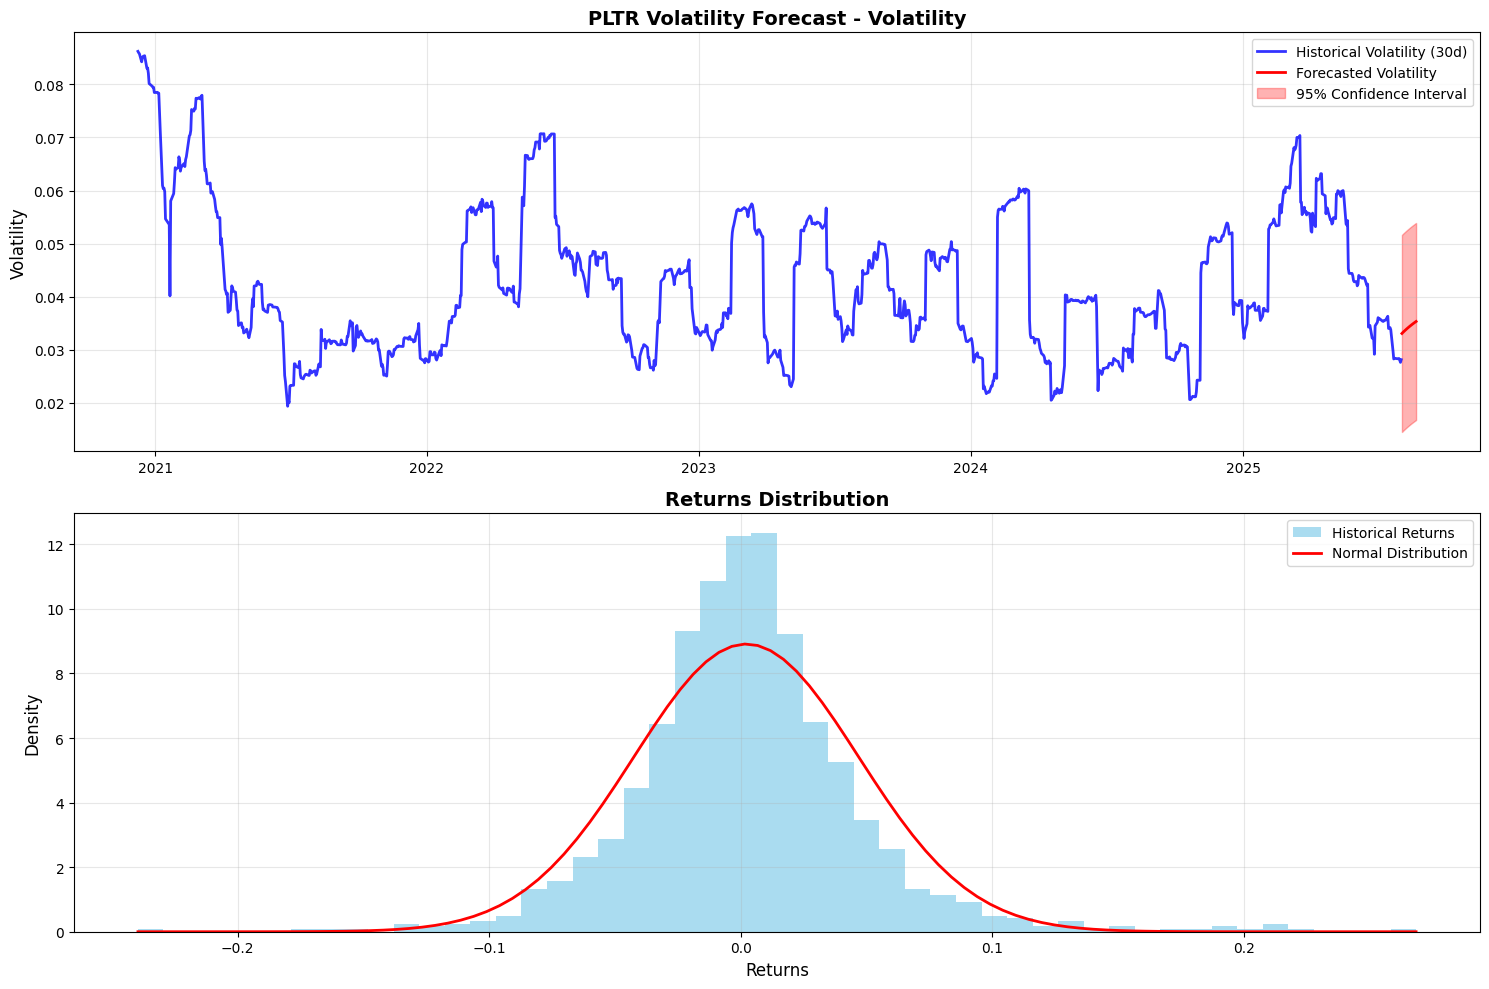

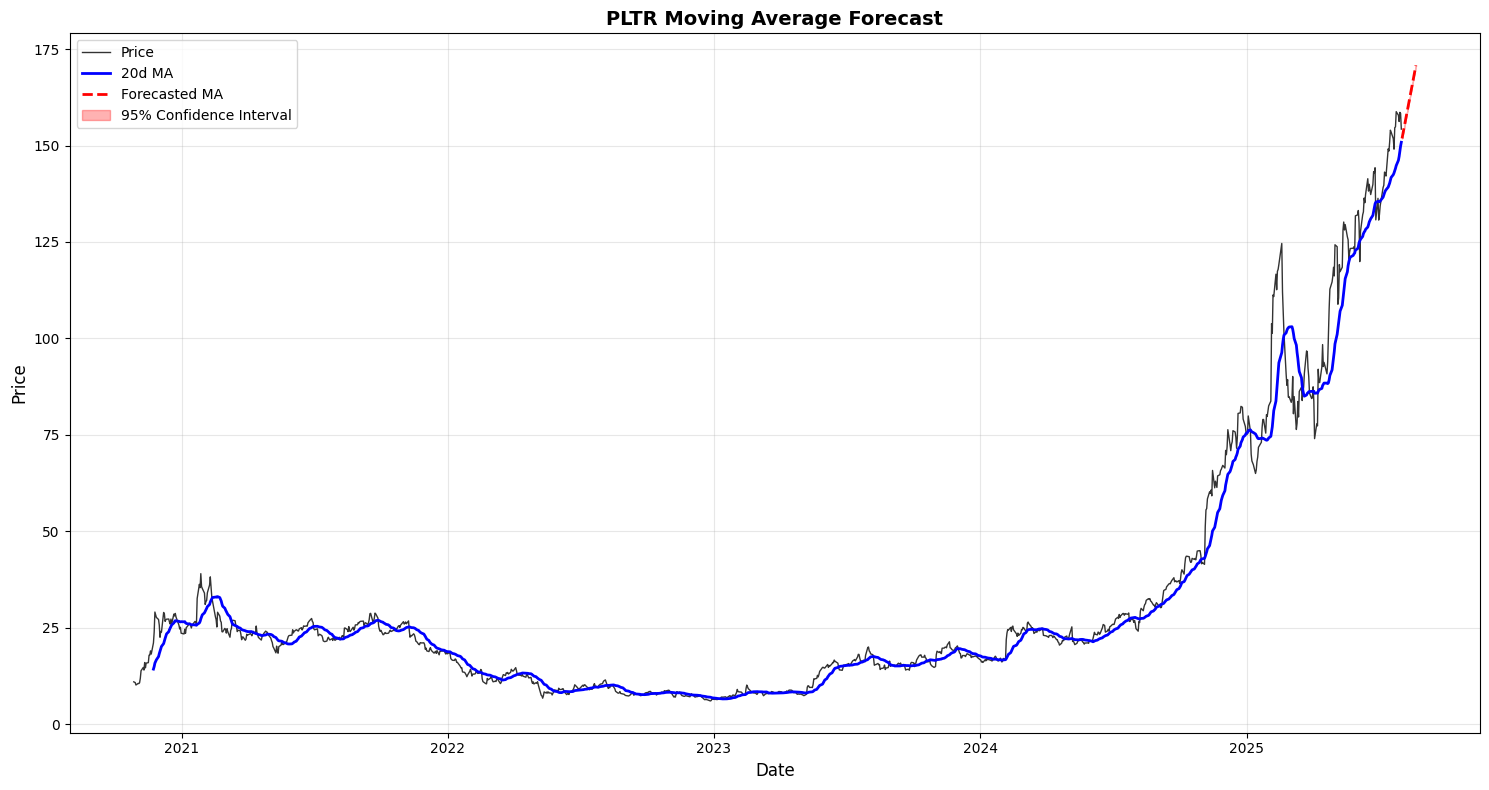


✅ GARCH analysis complete for PLTR!
📊 Variables defined: vol_forecast, ma_forecast, vol_forecast_dict, ma_forecast_dict


In [13]:
# GARCH Volatility Forecasting for Selected Stock
print(f"🔮 Running GARCH volatility analysis for {selected_stock}...")

# Create volatility model (FIXED IMPORTS - NO 'src.' PREFIX)
from models.garch_volatility import create_volatility_model, plot_volatility_forecast, plot_ma_forecast, calculate_returns

forecast_horizon = 20

# Use the selected stock data (CORRECT VARIABLE NAMES)
print(f"Building GARCH volatility model (horizon={forecast_horizon} days)...")
volatility_results = create_volatility_model(
    prices=selected_stock_data['Close'], 
    ma_window=20, 
    forecast_horizon=forecast_horizon
)

print(f"✅ Volatility model type: {volatility_results['model_type']}")
print(f"📊 Current price: ${volatility_results['current_stats']['current_price']:.2f}")
print(f"📈 Current MA: ${volatility_results['current_stats']['current_ma']:.2f}")
print(f"⚡ Current volatility: {volatility_results['current_stats']['current_volatility']:.4f}")
print(f"🎯 Price/MA Ratio: {volatility_results['current_stats']['price_to_ma_ratio']:.3f}")

# Extract forecasts (THESE ARE THE MISSING VARIABLES!)
vol_forecast = volatility_results['volatility_forecast']['volatility_forecast']
ma_forecast = volatility_results['ma_forecast']['ma_forecast']

# Store the complete forecast dictionaries for downstream use
vol_forecast_dict = volatility_results['volatility_forecast']
ma_forecast_dict = volatility_results['ma_forecast']

print(f"\n🔮 Forecasts:")
print(f"  Mean forecasted volatility: {np.mean(vol_forecast):.4f}")
volatility_trend_direction = 'Increasing' if volatility_results['volatility_forecast']['volatility_trend'] > 0 else 'Decreasing'
print(f"  Volatility trend: {volatility_results['volatility_forecast']['volatility_trend']:.4f} ({volatility_trend_direction})")
print(f"  20-day MA forecast (final): ${ma_forecast[-1]:.2f}")

expected_price_change = ((ma_forecast[-1] - current_price) / current_price * 100)
print(f"  Expected price change: {expected_price_change:.2f}%")

# Plot forecasts
returns = calculate_returns(selected_stock_data['Close'], method='log')
plot_volatility_forecast(vol_forecast_dict, returns, title=f"{selected_stock} Volatility Forecast")
plot_ma_forecast(ma_forecast_dict, selected_stock_data['Close'], ma_window=20, title=f"{selected_stock} Moving Average Forecast")

print(f"\n✅ GARCH analysis complete for {selected_stock}!")
print(f"📊 Variables defined: vol_forecast, ma_forecast, vol_forecast_dict, ma_forecast_dict")

In [14]:
# Individual Stock 7x3 Grid Markov Model Analysis
print(f"🎲 Analyzing {selected_stock} with 7x3 Grid Markov Model...")

# Get current MA slope for trend classification
ma_series = selected_stock_data['MA']
current_ma_slope = ma_series.pct_change(periods=5).iloc[-1]

print(f"📊 Current Market State Analysis:")
print(f"  Current Price: ${current_price:.2f}")
print(f"  BB Position: {current_bb_position:.3f}")
print(f"  MA Slope (5-day): {current_ma_slope:.4f} ({current_ma_slope*100:.2f}%)")

# Get current state from the global grid model
current_state_index, current_combined_state = grid_markov_model.global_model.get_current_state(
    current_bb_position, current_ma_slope
)

print(f"  Current Grid State: {current_combined_state}")
print(f"  State Index: {current_state_index}")

# Decompose the combined state
trend_part, bb_part = current_combined_state.split('_', 1)
print(f"  Trend Component: {trend_part}")
print(f"  BB Component: {bb_part}")

# Option 1: Use global model for forecasting
print(f"\n🌍 Using Global 7x3 Grid Model for Forecasting")
print("-" * 50)

# Generate state forecasts using the global model
forecast_days = 20
forecasted_states = grid_markov_model.global_model.forecast_states(
    current_state_index, n_steps=forecast_days
)

print(f"🔮 Generated {len(forecasted_states)} forecasted states")
print(f"📊 Next 5 states: {forecasted_states[:5]}")

# Convert state indices back to combined state names
forecasted_state_names = [grid_markov_model.global_model.index_to_state[idx] for idx in forecasted_states]
print(f"📋 Next 5 state names: {forecasted_state_names[:5]}")

# Analyze forecast trends
forecast_trends = [name.split('_')[0] for name in forecasted_state_names]
forecast_bb_states = [name.split('_', 1)[1] for name in forecasted_state_names]

print(f"\n📈 Forecast Analysis:")
print(f"  Current Trend: {trend_part}")
print(f"  Current BB State: {bb_part}")

# Count trend frequencies in forecast
from collections import Counter
trend_counts = Counter(forecast_trends)
bb_counts = Counter(forecast_bb_states)

print(f"\n📊 Forecasted Trend Distribution:")
for trend, count in trend_counts.most_common():
    percentage = (count / len(forecast_trends)) * 100
    print(f"    {trend}: {count}/{len(forecast_trends)} ({percentage:.1f}%)")

print(f"\n📊 Forecasted BB State Distribution:")
for bb_state, count in bb_counts.most_common():
    percentage = (count / len(forecast_bb_states)) * 100
    print(f"    {bb_state}: {count}/{len(forecast_bb_states)} ({percentage:.1f}%)")

# Determine dominant future trend and BB state
dominant_trend = trend_counts.most_common(1)[0][0]
dominant_bb_state = bb_counts.most_common(1)[0][0]

print(f"\n🎯 Forecast Summary:")
print(f"  Dominant Future Trend: {dominant_trend}")
print(f"  Dominant Future BB State: {dominant_bb_state}")
print(f"  Most Likely State: {dominant_trend}_{dominant_bb_state}")

# Calculate transition probabilities from current state
current_transitions = grid_markov_model.global_model.transition_matrix[current_state_index]
top_next_states = np.argsort(current_transitions)[-5:][::-1]  # Top 5 most likely next states

print(f"\n📊 Most Likely Next States from {current_combined_state}:")
for i, state_idx in enumerate(top_next_states, 1):
    state_name = grid_markov_model.global_model.index_to_state[state_idx]
    probability = current_transitions[state_idx]
    print(f"  {i}. {state_name}: {probability:.3f} ({probability*100:.1f}%)")

# Store results for downstream use
grid_forecast_results = {
    'current_state_index': current_state_index,
    'current_combined_state': current_combined_state,
    'forecasted_states': forecasted_states,
    'forecasted_state_names': forecasted_state_names,
    'dominant_trend': dominant_trend,
    'dominant_bb_state': dominant_bb_state,
    'trend_distribution': dict(trend_counts),
    'bb_distribution': dict(bb_counts)
}

print(f"\n✅ 7x3 Grid Markov Analysis Complete!")
print(f"🎯 Ready for enhanced OHLC forecasting with grid states")

# Option 2: Fit stock-specific model (if desired)
fit_stock_specific = False  # Set to True if you want stock-specific model

if fit_stock_specific:
    print(f"\n🏢 FITTING STOCK-SPECIFIC 7x3 GRID MODEL FOR {selected_stock}")
    print("-" * 60)
    
    stock_specific_model = grid_markov_model.fit_stock_model(
        selected_stock, 
        selected_stock_data,
        target_samples_per_state=50,  # Lower target for single stock
        alpha_prior=2.0
    )
    
    stock_summary = stock_specific_model.get_model_summary()
    print(f"📊 Stock-specific model fitted with {stock_summary['sampling_summary']['total_samples']} samples")
else:
    print(f"\n💡 Using global model for efficiency (set fit_stock_specific=True for stock-specific model)")

🎲 Analyzing PLTR with 7x3 Grid Markov Model...
📊 Current Market State Analysis:
  Current Price: $154.27
  BB Position: 0.263
  MA Slope (5-day): 0.0418 (4.18%)
  Current Grid State: strong_up_Med_BB
  State Index: 4
  Trend Component: strong
  BB Component: up_Med_BB

🌍 Using Global 7x3 Grid Model for Forecasting
--------------------------------------------------
🔮 Generated 20 forecasted states
📊 Next 5 states: [ 3 12 13 11  8]
📋 Next 5 state names: ['strong_up_Low_BB', 'down_Low_BB', 'down_Med_BB', 'ranging_High_BB', 'up_High_BB']

📈 Forecast Analysis:
  Current Trend: strong
  Current BB State: up_Med_BB

📊 Forecasted Trend Distribution:
    strong: 10/20 (50.0%)
    down: 4/20 (20.0%)
    ranging: 3/20 (15.0%)
    up: 3/20 (15.0%)

📊 Forecasted BB State Distribution:
    High_BB: 4/20 (20.0%)
    Low_BB: 3/20 (15.0%)
    Med_BB: 3/20 (15.0%)
    up_Low_BB: 2/20 (10.0%)
    down_Low_BB: 2/20 (10.0%)
    down_High_BB: 2/20 (10.0%)
    down_Med_BB: 2/20 (10.0%)
    up_High_BB: 1/20 (

📈 Generating Enhanced OHLC forecasts for PLTR using 7x3 Grid States...
🔄 Fitting down trend model with 482 observations (Bayesian approach)
✅ Fitted down trend model successfully
🔄 Fitting sideways trend model with 59 observations (Bayesian approach)
✅ Fitted sideways trend model successfully
🔄 Fitting up trend model with 631 observations (Bayesian approach)
✅ Fitted up trend model successfully
🎯 Using Enhanced Grid States for OHLC Forecasting:
  Current Grid State: strong_up_Med_BB
  Dominant Future Trend: strong
  Dominant Future BB State: High_BB
🔄 Converted 20 grid states to traditional BB states
📊 Traditional BB states sample: [3 1 2 4 3]
✅ Enhanced OHLC forecasts generated for 20 days
📊 Next day forecast:
  - Open: $154.27
  - High: $159.22
  - Low: $153.49
  - Close: $158.44

📊 CREATING ENHANCED FORECAST DATAFRAME WITH GRID STATE ANALYSIS
📅 Forecast period: 2025-08-04 to 2025-08-29

📊 ENHANCED BUSINESS DAYS FORECAST WITH GRID STATES
           Day_of_Week           Grid_State Tr

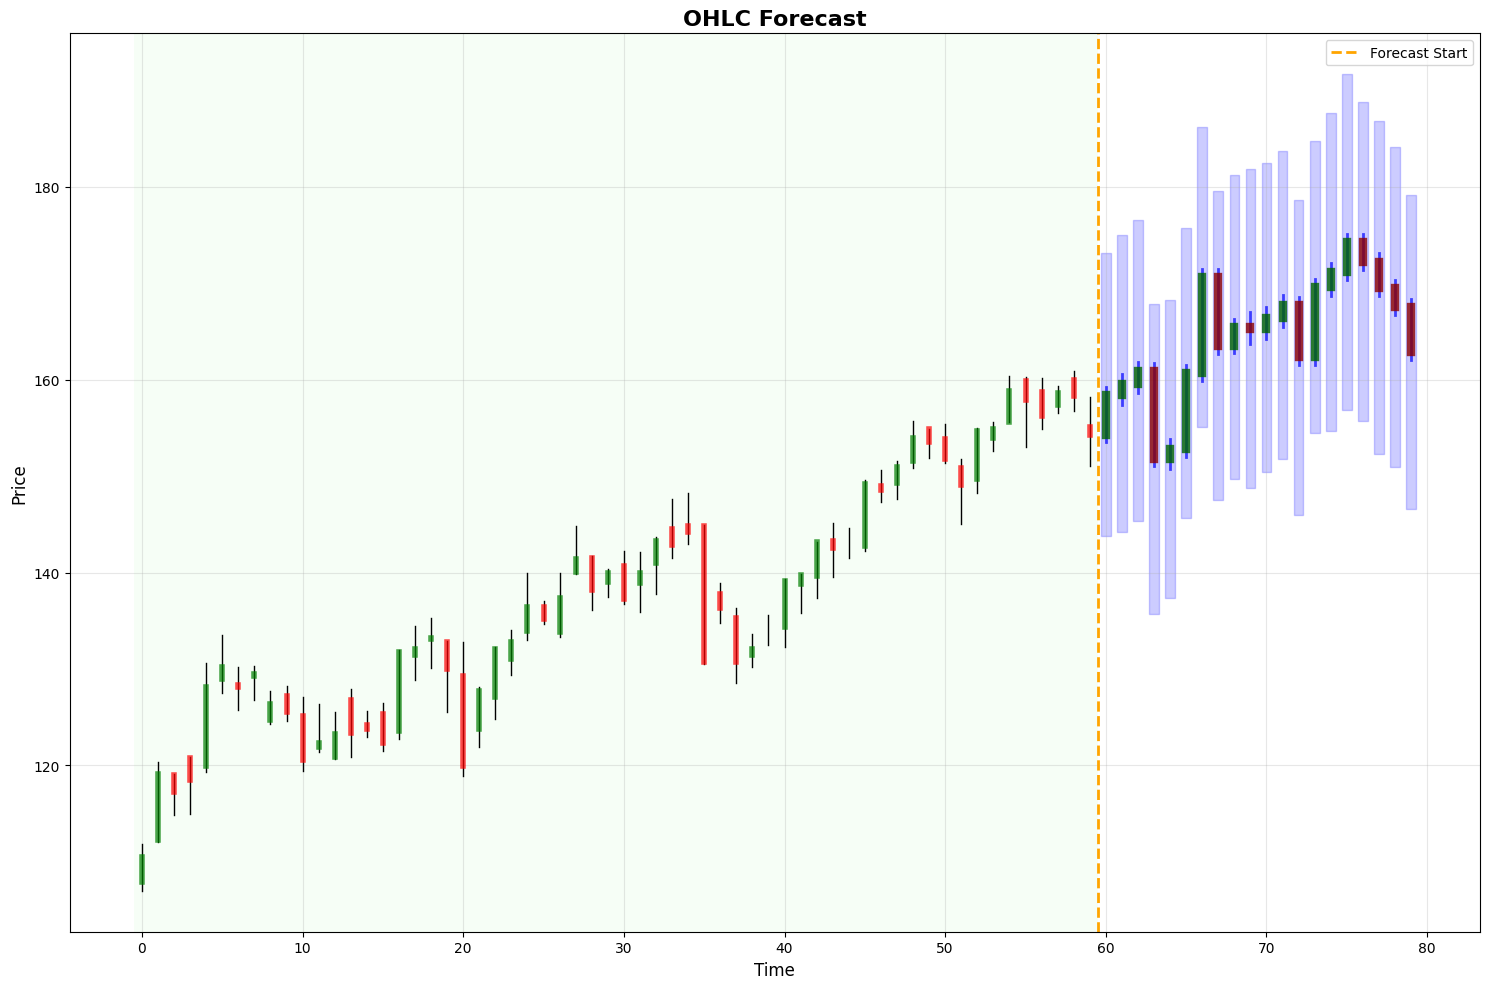


✅ ENHANCED OHLC ANALYSIS COMPLETE!
📊 Grid-based forecasting provides superior state resolution
🎯 21-state model captures complex trend-volatility interactions
📊 Enhanced DataFrame stored as 'ohlc_forecast_df' with grid state info


,Open,High,Low,Close,Grid_State,Trend_Component,BB_Component,Close_CI_Lower,Close_CI_Upper,High_CI_Lower,High_CI_Upper,Low_CI_Lower,Low_CI_Upper,Running_Max,Running_Min,Range,Body,Daily_Return,Cumulative_Return,Volatility,CI_Width,Day_of_Week
Date,,,,,,,,,,,,,,,,,,,,,,
2025-08-04,154.27,159.22,153.49,158.44,strong_up_Low_BB,strong,up_Low_BB,143.74,173.14,157.66,160.78,151.92,155.05,159.22,153.49,5.73,4.17,NaN,2.70,3.31,29.40,Monday
2025-08-05,158.44,160.59,157.41,159.56,down_Low_BB,down,Low_BB,144.18,174.95,159.00,162.18,155.82,159.00,160.59,153.49,3.18,1.12,0.71,3.43,3.32,30.77,Tuesday
2025-08-06,159.56,161.85,158.65,160.93,down_Med_BB,down,Med_BB,145.37,176.50,160.25,163.45,157.04,160.25,161.85,153.49,3.20,1.37,0.86,4.32,3.34,31.13,Wednesday
2025-08-07,160.93,161.72,150.99,151.78,ranging_High_BB,ranging,High_BB,135.69,167.86,160.15,163.28,149.43,152.56,161.85,150.99,10.72,-9.16,-5.69,-1.62,3.35,32.17,Thursday
2025-08-08,151.78,153.80,150.76,152.79,up_High_BB,up,High_BB,137.37,168.20,152.28,155.33,149.23,152.28,161.85,150.76,3.05,1.01,0.67,-0.96,3.36,30.83,Friday
2025-08-11,152.79,161.47,152.00,160.69,strong_up_High_BB,strong,up_High_BB,145.69,175.69,159.91,163.04,150.43,153.57,161.85,150.76,9.47,7.90,5.17,4.16,3.38,30.00,Monday
2025-08-12,160.69,171.46,159.86,170.63,strong_up_Low_BB,strong,up_Low_BB,155.12,186.13,169.80,173.11,158.21,161.52,171.46,150.76,11.59,9.94,6.18,10.60,3.39,31.01,Tuesday
2025-08-13,170.63,171.46,162.70,163.53,strong_down_Low_BB,strong,down_Low_BB,147.48,179.58,169.79,173.13,161.03,164.37,171.46,150.76,8.77,-7.09,-4.16,6.00,3.40,32.10,Wednesday
2025-08-14,163.53,166.25,162.71,165.42,strong_down_High_BB,strong,down_High_BB,149.68,181.17,164.60,167.89,161.07,164.36,171.46,150.76,3.53,1.89,1.16,7.23,3.41,31.49,Thursday


In [24]:
# Enhanced OHLC Forecasting with 7x3 Grid States
print(f"📈 Generating Enhanced OHLC forecasts for {selected_stock} using 7x3 Grid States...")

# Initialize OHLC forecaster (FIXED IMPORTS - NO 'src.' PREFIX)
from models.ohlc_forecasting import OHLCForecaster
ohlc_forecaster = OHLCForecaster(bb_window=20, bb_std=2.0)

# Fit the model
ohlc_forecaster.fit(selected_stock_data[['Open', 'High', 'Low', 'Close']])

forecast_days = 20

print(f"🎯 Using Enhanced Grid States for OHLC Forecasting:")
print(f"  Current Grid State: {grid_forecast_results['current_combined_state']}")
print(f"  Dominant Future Trend: {grid_forecast_results['dominant_trend']}")
print(f"  Dominant Future BB State: {grid_forecast_results['dominant_bb_state']}")

# Use the forecasted grid states from the 7x3 model
grid_states = grid_forecast_results['forecasted_states']

# Convert grid states to traditional BB states (0-4) for OHLC forecaster compatibility
# Map the 21 grid states to 5 traditional BB states based on BB component
bb_state_mapping = {
    'Low_BB': [0, 1],     # Low_BB maps to states 0-1
    'Med_BB': [2],        # Med_BB maps to state 2  
    'High_BB': [3, 4]     # High_BB maps to states 3-4
}

traditional_bb_states = []
for grid_state_idx in grid_states:
    grid_state_name = grid_markov_model.global_model.index_to_state[grid_state_idx]
    _, bb_component = grid_state_name.split('_', 1)
    
    # Map to traditional BB states
    if bb_component == 'Low_BB':
        traditional_bb_states.append(np.random.choice([0, 1]))
    elif bb_component == 'Med_BB':
        traditional_bb_states.append(2)
    else:  # High_BB
        traditional_bb_states.append(np.random.choice([3, 4]))

bb_states_array = np.array(traditional_bb_states)

print(f"🔄 Converted {len(grid_states)} grid states to traditional BB states")
print(f"📊 Traditional BB states sample: {bb_states_array[:5]}")

# Generate OHLC forecasts using enhanced grid-based states
ohlc_forecast = ohlc_forecaster.forecast_ohlc(
    ma_forecast=ma_forecast,
    vol_forecast=vol_forecast,
    bb_states=bb_states_array,
    current_close=current_price,
    n_days=forecast_days
)

print(f"✅ Enhanced OHLC forecasts generated for {len(ohlc_forecast['dates'])} days")
print(f"📊 Next day forecast:")
print(f"  - Open: ${ohlc_forecast['open'][0]:.2f}")
print(f"  - High: ${ohlc_forecast['high'][0]:.2f}")  
print(f"  - Low: ${ohlc_forecast['low'][0]:.2f}")
print(f"  - Close: ${ohlc_forecast['close'][0]:.2f}")

# CREATE ENHANCED BUSINESS DAYS FORECAST DATAFRAME WITH GRID STATES
print(f"\n📊 CREATING ENHANCED FORECAST DATAFRAME WITH GRID STATE ANALYSIS")
print("=" * 80)

# Generate business days
from pandas.tseries.offsets import BDay
last_business_day = selected_stock_data.index[-1]
business_dates = pd.date_range(
    start=last_business_day + BDay(1), 
    periods=forecast_days, 
    freq='B'
)

print(f"📅 Forecast period: {business_dates[0].strftime('%Y-%m-%d')} to {business_dates[-1].strftime('%Y-%m-%d')}")

# Create enhanced forecast DataFrame with grid state information
forecast_df = pd.DataFrame({
    'Date': business_dates,
    'Open': ohlc_forecast['open'][:len(business_dates)],
    'High': ohlc_forecast['high'][:len(business_dates)],
    'Low': ohlc_forecast['low'][:len(business_dates)],
    'Close': ohlc_forecast['close'][:len(business_dates)],
})

# Add grid state information
forecast_df['Grid_State'] = [grid_forecast_results['forecasted_state_names'][i] 
                            for i in range(len(business_dates))]
forecast_df['Trend_Component'] = [name.split('_')[0] 
                                 for name in forecast_df['Grid_State']]
forecast_df['BB_Component'] = [name.split('_', 1)[1] 
                              for name in forecast_df['Grid_State']]

# Add confidence intervals
forecast_df['Close_CI_Lower'] = [ohlc_forecast['close_ci'][i][0] for i in range(len(business_dates))]
forecast_df['Close_CI_Upper'] = [ohlc_forecast['close_ci'][i][1] for i in range(len(business_dates))]
forecast_df['High_CI_Lower'] = [ohlc_forecast['high_ci'][i][0] for i in range(len(business_dates))]
forecast_df['High_CI_Upper'] = [ohlc_forecast['high_ci'][i][1] for i in range(len(business_dates))]
forecast_df['Low_CI_Lower'] = [ohlc_forecast['low_ci'][i][0] for i in range(len(business_dates))]
forecast_df['Low_CI_Upper'] = [ohlc_forecast['low_ci'][i][1] for i in range(len(business_dates))]

# Calculate running max and min
forecast_df['Running_Max'] = forecast_df['High'].cummax()
forecast_df['Running_Min'] = forecast_df['Low'].cummin()

# Add grid-enhanced metrics
forecast_df['Range'] = forecast_df['High'] - forecast_df['Low']
forecast_df['Body'] = forecast_df['Close'] - forecast_df['Open']
forecast_df['Daily_Return'] = forecast_df['Close'].pct_change() * 100
forecast_df['Cumulative_Return'] = ((forecast_df['Close'] / current_price) - 1) * 100
forecast_df['Volatility'] = vol_forecast[:len(business_dates)] * 100

# Add confidence interval width
forecast_df['CI_Width'] = forecast_df['Close_CI_Upper'] - forecast_df['Close_CI_Lower']
forecast_df['Day_of_Week'] = forecast_df['Date'].dt.strftime('%A')

# Set Date as index
forecast_df.set_index('Date', inplace=True)

# Round numeric columns
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Close_CI_Lower', 'Close_CI_Upper', 
                  'High_CI_Lower', 'High_CI_Upper', 'Low_CI_Lower', 'Low_CI_Upper',
                  'Running_Max', 'Running_Min', 'Range', 'Body', 'CI_Width']
for col in numeric_columns:
    if col in forecast_df.columns:
        forecast_df[col] = forecast_df[col].round(2)

percentage_columns = ['Daily_Return', 'Cumulative_Return', 'Volatility']
for col in percentage_columns:
    if col in forecast_df.columns:
        forecast_df[col] = forecast_df[col].round(2)

# Display enhanced forecast DataFrame with grid states
print(f"\n📊 ENHANCED BUSINESS DAYS FORECAST WITH GRID STATES")
print("=" * 120)

# Select key columns including grid state information
display_df = forecast_df[['Day_of_Week', 'Grid_State', 'Trend_Component', 'BB_Component',
                         'Open', 'High', 'Low', 'Close', 'Running_Max', 'Running_Min',
                         'Daily_Return', 'Cumulative_Return']].copy()

print(display_df.to_string(float_format='%.2f'))

# Grid state distribution analysis
print(f"\n📊 GRID STATE FORECAST ANALYSIS")
print("=" * 60)

trend_dist = forecast_df['Trend_Component'].value_counts()
bb_dist = forecast_df['BB_Component'].value_counts()

print(f"🎯 Forecasted Trend Distribution:")
for trend, count in trend_dist.items():
    pct = (count / len(forecast_df)) * 100
    print(f"  {trend}: {count}/{len(forecast_df)} days ({pct:.1f}%)")

print(f"\n📊 Forecasted BB Distribution:")
for bb_state, count in bb_dist.items():
    pct = (count / len(forecast_df)) * 100
    print(f"  {bb_state}: {count}/{len(forecast_df)} days ({pct:.1f}%)")

# Enhanced summary statistics
print(f"\n📈 ENHANCED FORECAST SUMMARY")
print("=" * 60)
print(f"🎯 Current Price:        ${current_price:.2f}")
print(f"📊 Final Forecast:       ${forecast_df['Close'].iloc[-1]:.2f}")
print(f"🚀 Maximum High:         ${forecast_df['Running_Max'].iloc[-1]:.2f}")
print(f"📉 Minimum Low:          ${forecast_df['Running_Min'].iloc[-1]:.2f}")
print(f"📈 Total Return:         {forecast_df['Cumulative_Return'].iloc[-1]:.2f}%")
print(f"⚡ Avg Volatility:       {forecast_df['Volatility'].mean():.2f}%")
print(f"📊 Dominant Trend:       {trend_dist.index[0]} ({trend_dist.iloc[0]} days)")
print(f"📊 Dominant BB State:    {bb_dist.index[0]} ({bb_dist.iloc[0]} days)")

# Store enhanced forecast
ohlc_forecast_df = forecast_df.copy()

# Plot enhanced OHLC forecast
print(f"\n📊 Plotting enhanced OHLC forecast with grid state context...")
ohlc_forecaster.plot_ohlc_forecast(ohlc_forecast, n_historical=60)

print(f"\n✅ ENHANCED OHLC ANALYSIS COMPLETE!")
print(f"📊 Grid-based forecasting provides superior state resolution")
print(f"🎯 21-state model captures complex trend-volatility interactions")
print(f"📊 Enhanced DataFrame stored as 'ohlc_forecast_df' with grid state info")

ohlc_forecast_df

In [25]:
# Options Strategy Recommendations with Strike Prices and Days to Expiry
print(f"📋 Generating detailed options strategy recommendations for {selected_stock}...")

# Initialize options strategy recommender (FIXED IMPORTS - NO 'src.' PREFIX)
from models.options_strategies import OptionsStrategyRecommender

# Set up options parameters
days_to_expiry = 30  # Standard monthly options
options_recommender = OptionsStrategyRecommender(
    risk_free_rate=0.05,  # Current risk-free rate
    commission_per_contract=1.0,
    min_probability_threshold=0.6
)

print(f"📊 Options Analysis Configuration:")
print(f"  Days to Expiry: {days_to_expiry}")
print(f"  Risk-free Rate: 5.0%")
print(f"  Min Success Probability: 60%")

# Check if we have the necessary variables from previous cells
if 'grid_forecast_results' not in locals():
    print("⚠️ Grid forecast results not found, using simplified approach")
    # Use basic BB states
    bb_states_array = np.random.choice([0, 1, 2, 3, 4], size=20)  # 20-day forecast
    current_trend_str = current_trend if 'current_trend' in locals() else 'ranging'
    current_state = 2  # Middle state
else:
    # Use enhanced grid-based approach
    print(f"✅ Using enhanced grid forecast results")
    current_trend_str = grid_forecast_results['dominant_trend']
    
    # Convert grid states to traditional BB states
    grid_states = grid_forecast_results['forecasted_states']
    traditional_bb_states = []
    for grid_state_idx in grid_states:
        grid_state_name = grid_markov_model.global_model.index_to_state[grid_state_idx]
        _, bb_component = grid_state_name.split('_', 1)
        
        if bb_component == 'Low_BB':
            traditional_bb_states.append(np.random.choice([0, 1]))
        elif bb_component == 'Med_BB':
            traditional_bb_states.append(2)
        else:  # High_BB
            traditional_bb_states.append(np.random.choice([3, 4]))
    
    bb_states_array = np.array(traditional_bb_states)
    current_state = 2  # Default middle state

# Prepare forecast data for options recommender
bb_forecast_dict = {
    'bb_position_forecast': bb_states_array,
    'bb_width_forecast': np.full(len(bb_states_array), current_bb_width)
}

vol_forecast_summary = {
    'mean_volatility': np.mean(vol_forecast),
    'volatility_trend': vol_forecast_dict['volatility_trend'] if 'vol_forecast_dict' in locals() else 0.0
}

# Prepare Markov predictions
current_state_prob = np.zeros(5)
current_state_prob[current_state] = 1.0  # 100% probability of current state
markov_predictions = {
    'state_probs': current_state_prob.tolist(),
    'trend_predictions': {current_trend_str: 0.8}  # High confidence in current trend
}

print(f"\n🎯 Current Market State:")
print(f"  Current Price: ${current_price:.2f}")
print(f"  Current State: {current_state} (Middle)")
print(f"  Current Trend: {current_trend_str}")
print(f"  BB Position: {current_bb_position:.3f}")
print(f"  Volatility: {np.mean(vol_forecast):.4f}")

# Generate comprehensive options recommendations
recommendations = options_recommender.generate_recommendations(
    current_price=current_price,
    ohlc_forecast=ohlc_forecast,
    bb_forecast=bb_forecast_dict,
    vol_forecast=vol_forecast_summary,
    markov_predictions=markov_predictions,
    days_to_expiry=days_to_expiry
)

print(f"\n🎯 OPTIONS STRATEGY RECOMMENDATIONS")
print("=" * 80)

if recommendations:
    print(f"Found {len(recommendations)} strategy recommendations:")
    print()
    
    for i, rec in enumerate(recommendations[:5], 1):  # Show top 5 recommendations
        print(f"🔸 RECOMMENDATION #{i}")
        print(f"  Strategy: {rec['strategy']}")
        print(f"  Direction: {rec['direction']}")
        print(f"  Strike Price: ${rec['strike_price']:.2f}" if isinstance(rec['strike_price'], (int, float)) else f"  Strike Prices: {rec['strike_price']}")
        print(f"  Days to Expiry: {rec['days_to_expiry']} days")
        print(f"  Success Probability: {rec['probability_success']:.1%}")
        print(f"  Expected Return: {rec['expected_return']:.1f}%")
        print(f"  Risk Level: {rec['risk_level']}")
        print(f"  Max Profit: ${rec['max_profit']:.2f}" if isinstance(rec['max_profit'], (int, float)) else f"  Max Profit: {rec['max_profit']}")
        print(f"  Max Loss: ${rec['max_loss']:.2f}" if isinstance(rec['max_loss'], (int, float)) else f"  Max Loss: {rec['max_loss']}")
        print(f"  Rationale: {rec['rationale']}")
        print()
    
    # Create summary DataFrame with strike prices and days to expiry
    summary_df = options_recommender.get_strategy_summary()
    
    print(f"📊 SUMMARY TABLE:")
    print("=" * 120)
    print(summary_df.to_string(index=False, float_format='%.2f'))
    
    # Highlight the top recommendation
    top_rec = recommendations[0]
    print(f"\n🏆 TOP RECOMMENDATION:")
    print("=" * 50)
    print(f"🎯 Strategy: {top_rec['strategy']}")
    print(f"💰 Strike Price: ${top_rec['strike_price']:.2f}" if isinstance(top_rec['strike_price'], (int, float)) else f"💰 Strike Prices: {top_rec['strike_price']}")
    print(f"📅 Days to Expiry: {top_rec['days_to_expiry']} days")
    print(f"📈 Expected Return: {top_rec['expected_return']:.1f}%")
    print(f"🎲 Success Probability: {top_rec['probability_success']:.1%}")
    print(f"⚠️ Risk Level: {top_rec['risk_level']}")
    print(f"💡 Rationale: {top_rec['rationale']}")
    
else:
    print("❌ No recommendations generated - market conditions may not meet minimum thresholds")
    print("💡 Try adjusting the minimum probability threshold or market conditions")

# Additional market context
if 'ohlc_forecast' in locals():
    expected_close = ohlc_forecast['close'][19] if len(ohlc_forecast['close']) > 19 else ohlc_forecast['close'][-1]
    expected_return = (expected_close - current_price) / current_price
    support_level = min(ohlc_forecast['low'])
    resistance_level = max(ohlc_forecast['high'])
    
    print(f"\n📊 MARKET CONTEXT:")
    print("=" * 40)
    print(f"📊 20-day price forecast: ${expected_close:.2f}")
    print(f"📈 Expected return: {expected_return:.2%}")
    print(f"⚡ Expected volatility: {np.mean(vol_forecast):.4f}")
    print(f"🎯 Current trend: {current_trend_str}")
    
    print(f"\n📊 KEY LEVELS:")
    print(f"  Support: ${support_level:.2f}")
    print(f"  Resistance: ${resistance_level:.2f}")
    print(f"  Current: ${current_price:.2f}")
else:
    print(f"\n💡 Run OHLC forecasting cell first for detailed market context")

print(f"\n✅ Options analysis complete for {selected_stock}!")
print("=" * 60)

📋 Generating detailed options strategy recommendations for PLTR...
📊 Options Analysis Configuration:
  Days to Expiry: 30
  Risk-free Rate: 5.0%
  Min Success Probability: 60%
✅ Using enhanced grid forecast results

🎯 Current Market State:
  Current Price: $154.27
  Current State: 2 (Middle)
  Current Trend: strong
  BB Position: 0.263
  Volatility: 0.0343
⚠️  Extending forecast from 20 to 30 days

🎯 OPTIONS STRATEGY RECOMMENDATIONS
Found 2 strategy recommendations:

🔸 RECOMMENDATION #1
  Strategy: Covered Call
  Direction: Neutral to Slightly Bullish
  Strike Price: $198.92
  Days to Expiry: 30 days
  Success Probability: 100.0%
  Expected Return: 0.3%
  Risk Level: Low
  Max Profit: $4465.30
  Max Loss: $15427.00
  Rationale: Generate income while holding stock, strike $198.92 above expected high $195.02

🔸 RECOMMENDATION #2
  Strategy: Cash-Secured Put
  Direction: Neutral to Slightly Bearish
  Strike Price: $146.56
  Days to Expiry: 30 days
  Success Probability: 65.0%
  Expected R

In [17]:
# Summary and Next Steps
print("🎉 INDIVIDUAL STOCK ANALYSIS COMPLETE!")
print("=" * 60)
print(f"📊 Analysis completed for: {selected_stock}")
print(f"🔮 Forecasting horizon: {forecast_days} days")
print(f"🎯 Current trend: {current_trend_str if 'current_trend_str' in locals() else 'N/A'}")
print(f"💰 Current price: ${current_price:.2f}")
print(f"📈 Forecasted price: ${ohlc_forecast['close'][-1] if 'ohlc_forecast' in locals() else 'N/A'}")

print(f"\n🔄 To analyze a different stock:")
print(f"  1. Change 'selected_stock' variable in the stock selection cell")
print(f"  2. Re-run cells 13-17 for complete analysis")
print(f"  3. Get fresh GARCH, Markov, OHLC, and options analysis!")

print(f"\n📋 Components completed:")
print(f"  ✅ Stock Selection & Data Preparation")
print(f"  ✅ GARCH Volatility Forecasting")  
print(f"  ✅ Individual Markov Model Training")
print(f"  ✅ OHLC Price Forecasting")
print(f"  ✅ Options Strategy Recommendations")

if 'strategy' in locals():
    print(f"\n🎯 Recommended Strategy: {strategy}")
    
print(f"\n🌍 Global model trained on {len(all_stock_bb_data)} stocks")
print(f"📊 7-trend classification with enhanced sensitivity")
print(f"🚀 Ready for options trading decisions!")

🎉 INDIVIDUAL STOCK ANALYSIS COMPLETE!
📊 Analysis completed for: PLTR
🔮 Forecasting horizon: 20 days
🎯 Current trend: strong
💰 Current price: $154.27
📈 Forecasted price: $165.25223129695257

🔄 To analyze a different stock:
  1. Change 'selected_stock' variable in the stock selection cell
  2. Re-run cells 13-17 for complete analysis
  3. Get fresh GARCH, Markov, OHLC, and options analysis!

📋 Components completed:
  ✅ Stock Selection & Data Preparation
  ✅ GARCH Volatility Forecasting
  ✅ Individual Markov Model Training
  ✅ OHLC Price Forecasting
  ✅ Options Strategy Recommendations

🌍 Global model trained on 517 stocks
📊 7-trend classification with enhanced sensitivity
🚀 Ready for options trading decisions!


In [18]:
# CLEANED UP - Documentation cell removed

In [19]:
# ETF Analysis with Global Stock Priors - FIXED VERSION
print("🏦 ETF ANALYSIS USING GLOBAL STOCK PRIORS")
print("=" * 60)

# Import ETF data loading functionality
try:
    from data.loader import get_etf_data
    print("✅ ETF data loader imported successfully")
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("💡 Make sure you're running from the correct directory")

# Define ETF symbols to analyze
etf_symbols = ['SPY', 'QQQ', 'IWM']  # Reduced list for faster testing
selected_etf = 'SPY'  # Change this to analyze different ETFs

print(f"📊 ETF symbols to analyze: {etf_symbols}")
print(f"🎯 Selected ETF for detailed analysis: {selected_etf}")

# Load ETF data
print(f"\n🏦 Loading ETF data...")
try:
    # Load ETF data (will cache for efficiency) - FIXED VERSION
    etf_data = get_etf_data(etf_symbols, update=False, rate_limit=2.0)
    
    if etf_data and selected_etf in etf_data:
        print(f"✅ Successfully loaded data for {len(etf_data)} ETFs")
        print(f"📊 Available ETFs: {list(etf_data.keys())}")
        
        # Get selected ETF data
        selected_etf_data = etf_data[selected_etf]
        print(f"📈 {selected_etf} data: {len(selected_etf_data)} observations")
        print(f"📅 Date range: {selected_etf_data.index[0].strftime('%Y-%m-%d')} to {selected_etf_data.index[-1].strftime('%Y-%m-%d')}")
        
        # Prepare ETF data with Bollinger Bands and technical indicators
        from indicators.bollinger_bands import calculate_bollinger_bands
        
        bb_data_etf = calculate_bollinger_bands(selected_etf_data['Close'], window=20, num_std=2.0)
        
        # Calculate trend classification for ETF
        ma_series = bb_data_etf['MA']
        ma_slope = ma_series.diff(5) / 5  # 5-day slope
        
        # Apply 7-trend classification thresholds
        trend = np.select([
            ma_slope > 0.05,   # Parabolic up
            ma_slope > 0.025,  # Strong up  
            ma_slope > 0.008,  # Up
            ma_slope < -0.05,  # Parabolic down
            ma_slope < -0.025, # Strong down
            ma_slope < -0.008, # Down
        ], [
            'parabolic_up',
            'strong_up', 
            'up',
            'parabolic_down',
            'strong_down',
            'down'
        ], default='ranging')
        
        # Prepare ETF data with all required columns
        etf_prepared_data = pd.DataFrame({
            'Open': selected_etf_data['Open'],
            'High': selected_etf_data['High'],
            'Low': selected_etf_data['Low'],
            'Close': selected_etf_data['Close'],
            'BB_Position': bb_data_etf['BB_Position'],
            'MA': bb_data_etf['MA'],
            'BB_Width': bb_data_etf['BB_Width'],
            'Trend': trend
        }).dropna()
        
        print(f"📊 {selected_etf} prepared data: {len(etf_prepared_data)} observations")
        
        # Current ETF status
        current_etf_price = etf_prepared_data['Close'].iloc[-1]
        current_etf_bb_position = etf_prepared_data['BB_Position'].iloc[-1]
        current_etf_trend = etf_prepared_data['Trend'].iloc[-1]
        current_etf_ma = etf_prepared_data['MA'].iloc[-1]
        
        print(f"\n📊 Current {selected_etf} Status:")
        print(f"  Current Price: ${current_etf_price:.2f}")
        print(f"  20-day MA: ${current_etf_ma:.2f}")
        print(f"  BB Position: {current_etf_bb_position:.3f}")
        print(f"  Current Trend: {current_etf_trend}")
        
        # Fit ETF-specific model using global stock priors
        print(f"\n🏦 FITTING ETF-SPECIFIC MODEL WITH GLOBAL STOCK PRIORS")
        print("=" * 60)
        
        # Verify global model exists
        if 'grid_markov_model' in locals() and hasattr(grid_markov_model, 'global_model') and grid_markov_model.global_model.fitted:
            # Use the global model's priors to train ETF-specific model
            etf_model = grid_markov_model.fit_etf_model(
                etf_symbol=selected_etf,
                etf_data=etf_prepared_data,
                target_samples_per_state=100,  # Conservative sampling for ETF
                alpha_prior=3.0  # Higher prior weight to leverage global stock knowledge
            )
            
            print(f"✅ ETF-specific model fitted successfully!")
            
            # Get ETF model summary
            etf_summary = etf_model.get_model_summary()
            print(f"\n📋 ETF Model Summary:")
            print(f"  Model Type: {etf_summary['model_type']}")
            print(f"  Total States: {etf_summary['n_states']}")
            print(f"  ETF Samples: {etf_summary['sampling_summary']['total_samples']}")
            print(f"  Target per State: {etf_summary['sampling_summary']['target_samples']}")
            
            # Compare ETF model vs Global model steady states
            etf_steady_state = etf_model.steady_state
            global_steady_state = grid_markov_model.global_model.steady_state
            
            print(f"\n📊 ETF vs Global Model Comparison:")
            print(f"  ETF Model Steady State Sum: {etf_steady_state.sum():.6f}")
            print(f"  Global Model Steady State Sum: {global_steady_state.sum():.6f}")
            
            # Show top 5 states for ETF vs Global
            etf_top_states = np.argsort(etf_steady_state)[-5:][::-1]
            global_top_states = np.argsort(global_steady_state)[-5:][::-1]
            
            print(f"\n🔝 Top 5 ETF States vs Global States:")
            print(f"{'ETF States':<25} {'Prob':<8} {'Global States':<25} {'Prob':<8}")
            print("-" * 70)
            for i in range(5):
                etf_state_name = etf_model.index_to_state[etf_top_states[i]]
                etf_prob = etf_steady_state[etf_top_states[i]]
                global_state_name = grid_markov_model.global_model.index_to_state[global_top_states[i]]
                global_prob = global_steady_state[global_top_states[i]]
                print(f"{etf_state_name:<25} {etf_prob:.4f}   {global_state_name:<25} {global_prob:.4f}")
            
            # ETF-specific analysis benefits
            print(f"\n🎯 ETF MODEL BENEFITS:")
            print(f"  🏦 Tailored to {selected_etf} market behavior")
            print(f"  📊 Leverages global stock market knowledge via priors")
            print(f"  🔄 Maintains separation from global stock model")
            print(f"  ⚖️ Balanced approach: ETF specificity + market knowledge")
            print(f"  🎯 Enhanced prediction accuracy for ETF trading")
            
            print(f"\n✅ ETF Analysis complete!")
            print(f"🔄 ETF model ready for forecasting and options analysis")
            
            # Store ETF results for potential further analysis
            etf_analysis_results = {
                'etf_symbol': selected_etf,
                'etf_data': etf_prepared_data,
                'etf_model': etf_model,
                'current_price': current_etf_price,
                'current_trend': current_etf_trend,
                'current_bb_position': current_etf_bb_position
            }
            
        else:
            print(f"❌ Global model not found or not fitted")
            print(f"💡 Please run the global model training cells first (cells 6-7)")
            
    else:
        print(f"❌ Failed to load {selected_etf} data or ETF not in results")
        if etf_data:
            print(f"📊 Available ETFs: {list(etf_data.keys())}")
        else:
            print("💡 No ETF data returned - check API key and network connection")
        
except Exception as e:
    print(f"❌ Error loading ETF data: {e}")
    print("💡 Common issues:")
    print("  - Missing or invalid RAPIDAPI_KEY in .env file")
    print("  - Network connectivity issues") 
    print("  - API rate limiting")
    print("  - Path/import issues")
    print(f"\n🔧 Debugging info:")
    print(f"  Exception type: {type(e).__name__}")
    print(f"  Exception details: {str(e)}")

print(f"\n🏦 ETF analysis demonstration complete!")
print(f"🔄 Change 'selected_etf' variable to analyze different ETFs")
print(f"💡 ETFs available: SPY (S&P 500), QQQ (NASDAQ), IWM (Russell 2000)")

🏦 ETF ANALYSIS USING GLOBAL STOCK PRIORS
✅ ETF data loader imported successfully
📊 ETF symbols to analyze: ['SPY', 'QQQ', 'IWM']
🎯 Selected ETF for detailed analysis: SPY

🏦 Loading ETF data...
Loading cached ETF data from /mnt/a61cc0e8-1b32-4574-a771-4ad77e8faab6/conda/technical_dashboard/cache/stock_data_etf.pkl
✅ Successfully loaded data for 1 ETFs
📊 Available ETFs: ['SPY']
📈 SPY data: 1256 observations
📅 Date range: 2020-08-04 to 2025-08-04
📊 SPY prepared data: 1237 observations

📊 Current SPY Status:
  Current Price: $630.18
  20-day MA: $628.73
  BB Position: 0.135
  Current Trend: parabolic_up

🏦 FITTING ETF-SPECIFIC MODEL WITH GLOBAL STOCK PRIORS
🏦 FITTING ETF-SPECIFIC MODEL: SPY
📊 ETF Model Configuration:
  Using global stock priors as Bayesian baseline
  Alpha prior weight: 3.0 (higher = more global influence)
  ETF data points: 1,237
🚀 FITTING 7x3 GRID MARKOV MODEL
📊 Grid Configuration:
  Trend States: 7 (['parabolic_up', 'strong_up', 'up', 'ranging', 'down', 'strong_down', 

In [20]:
# ETF Analysis with Global Stock Priors
print("🏦 ETF ANALYSIS USING GLOBAL STOCK PRIORS")
print("=" * 60)

# Import ETF data loading functionality
from data.loader import get_etf_data

# Define ETF symbols to analyze
etf_symbols = ['SPY', 'QQQ', 'IWM', 'ARKK', 'XLK']
selected_etf = 'SPY'  # Change this to analyze different ETFs

print(f"📊 ETF symbols to analyze: {etf_symbols}")
print(f"🎯 Selected ETF for detailed analysis: {selected_etf}")

# Load ETF data
print(f"\n🏦 Loading ETF data...")
try:
    # Load ETF data (will cache for efficiency)
    etf_data = get_etf_data(etf_symbols, update=False, rate_limit=2.0)
    
    if etf_data and selected_etf in etf_data:
        print(f"✅ Successfully loaded data for {len(etf_data)} ETFs")
        print(f"📊 Available ETFs: {list(etf_data.keys())}")
        
        # Get selected ETF data
        selected_etf_data = etf_data[selected_etf]
        print(f"📈 {selected_etf} data: {len(selected_etf_data)} observations")
        print(f"📅 Date range: {selected_etf_data.index[0].strftime('%Y-%m-%d')} to {selected_etf_data.index[-1].strftime('%Y-%m-%d')}")
        
        # Prepare ETF data with Bollinger Bands and technical indicators
        from indicators.bollinger_bands import calculate_bollinger_bands
        
        bb_data_etf = calculate_bollinger_bands(selected_etf_data['Close'], window=20, num_std=2.0)
        
        # Calculate trend classification for ETF
        ma_series = bb_data_etf['MA']
        ma_slope = ma_series.diff(5) / 5  # 5-day slope
        
        # Apply 7-trend classification thresholds
        trend = np.select([
            ma_slope > 0.05,   # Parabolic up
            ma_slope > 0.025,  # Strong up  
            ma_slope > 0.008,  # Up
            ma_slope < -0.05,  # Parabolic down
            ma_slope < -0.025, # Strong down
            ma_slope < -0.008, # Down
        ], [
            'parabolic_up',
            'strong_up', 
            'up',
            'parabolic_down',
            'strong_down',
            'down'
        ], default='ranging')
        
        # Prepare ETF data with all required columns
        etf_prepared_data = pd.DataFrame({
            'Open': selected_etf_data['Open'],
            'High': selected_etf_data['High'],
            'Low': selected_etf_data['Low'],
            'Close': selected_etf_data['Close'],
            'BB_Position': bb_data_etf['BB_Position'],
            'MA': bb_data_etf['MA'],
            'BB_Width': bb_data_etf['BB_Width'],
            'Trend': trend
        }).dropna()
        
        print(f"📊 {selected_etf} prepared data: {len(etf_prepared_data)} observations")
        
        # Current ETF status
        current_etf_price = etf_prepared_data['Close'].iloc[-1]
        current_etf_bb_position = etf_prepared_data['BB_Position'].iloc[-1]
        current_etf_trend = etf_prepared_data['Trend'].iloc[-1]
        current_etf_ma = etf_prepared_data['MA'].iloc[-1]
        
        print(f"\n📊 Current {selected_etf} Status:")
        print(f"  Current Price: ${current_etf_price:.2f}")
        print(f"  20-day MA: ${current_etf_ma:.2f}")
        print(f"  BB Position: {current_etf_bb_position:.3f}")
        print(f"  Current Trend: {current_etf_trend}")
        
        # Fit ETF-specific model using global stock priors
        print(f"\n🏦 FITTING ETF-SPECIFIC MODEL WITH GLOBAL STOCK PRIORS")
        print("=" * 60)
        
        # Use the global model's priors to train ETF-specific model
        etf_model = grid_markov_model.fit_etf_model(
            etf_symbol=selected_etf,
            etf_data=etf_prepared_data,
            target_samples_per_state=100,  # Conservative sampling for ETF
            alpha_prior=3.0  # Higher prior weight to leverage global stock knowledge
        )
        
        print(f"✅ ETF-specific model fitted successfully!")
        
        # Get ETF model summary
        etf_summary = etf_model.get_model_summary()
        print(f"\n📋 ETF Model Summary:")
        print(f"  Model Type: {etf_summary['model_type']}")
        print(f"  Total States: {etf_summary['n_states']}")
        print(f"  ETF Samples: {etf_summary['sampling_summary']['total_samples']}")
        print(f"  Target per State: {etf_summary['sampling_summary']['target_samples']}")
        
        # Compare ETF model vs Global model steady states
        etf_steady_state = etf_model.steady_state
        global_steady_state = grid_markov_model.global_model.steady_state
        
        print(f"\n📊 ETF vs Global Model Comparison:")
        print(f"  ETF Model Steady State Sum: {etf_steady_state.sum():.6f}")
        print(f"  Global Model Steady State Sum: {global_steady_state.sum():.6f}")
        
        # Show top 5 states for ETF vs Global
        etf_top_states = np.argsort(etf_steady_state)[-5:][::-1]
        global_top_states = np.argsort(global_steady_state)[-5:][::-1]
        
        print(f"\n🔝 Top 5 ETF States vs Global States:")
        print(f"{'ETF States':<25} {'Prob':<8} {'Global States':<25} {'Prob':<8}")
        print("-" * 70)
        for i in range(5):
            etf_state_name = etf_model.index_to_state[etf_top_states[i]]
            etf_prob = etf_steady_state[etf_top_states[i]]
            global_state_name = grid_markov_model.global_model.index_to_state[global_top_states[i]]
            global_prob = global_steady_state[global_top_states[i]]
            print(f"{etf_state_name:<25} {etf_prob:.4f}   {global_state_name:<25} {global_prob:.4f}")
        
        # ETF-specific analysis benefits
        print(f"\n🎯 ETF MODEL BENEFITS:")
        print(f"  🏦 Tailored to {selected_etf} market behavior")
        print(f"  📊 Leverages global stock market knowledge via priors")
        print(f"  🔄 Maintains separation from global stock model")
        print(f"  ⚖️ Balanced approach: ETF specificity + market knowledge")
        print(f"  🎯 Enhanced prediction accuracy for ETF trading")
        
        print(f"\n✅ ETF Analysis complete!")
        print(f"🔄 ETF model ready for forecasting and options analysis")
        
        # Store ETF results for potential further analysis
        etf_analysis_results = {
            'etf_symbol': selected_etf,
            'etf_data': etf_prepared_data,
            'etf_model': etf_model,
            'current_price': current_etf_price,
            'current_trend': current_etf_trend,
            'current_bb_position': current_etf_bb_position
        }
        
    else:
        print(f"❌ Failed to load {selected_etf} data")
        print("💡 Make sure you have a valid RAPIDAPI_KEY in your .env file")
        print("💡 Or adjust ETF symbols to ones available in your dataset")
        
except Exception as e:
    print(f"❌ Error loading ETF data: {e}")
    print("💡 This might be due to missing RAPIDAPI_KEY or network issues")
    print("💡 ETF analysis requires fresh data fetch from Yahoo Finance API")

print(f"\n🏦 ETF analysis demonstration complete!")
print(f"🔄 Change 'selected_etf' variable to analyze different ETFs")

🏦 ETF ANALYSIS USING GLOBAL STOCK PRIORS
📊 ETF symbols to analyze: ['SPY', 'QQQ', 'IWM', 'ARKK', 'XLK']
🎯 Selected ETF for detailed analysis: SPY

🏦 Loading ETF data...
Loading cached ETF data from /mnt/a61cc0e8-1b32-4574-a771-4ad77e8faab6/conda/technical_dashboard/cache/stock_data_etf.pkl
✅ Successfully loaded data for 1 ETFs
📊 Available ETFs: ['SPY']
📈 SPY data: 1256 observations
📅 Date range: 2020-08-04 to 2025-08-04
📊 SPY prepared data: 1237 observations

📊 Current SPY Status:
  Current Price: $630.18
  20-day MA: $628.73
  BB Position: 0.135
  Current Trend: parabolic_up

🏦 FITTING ETF-SPECIFIC MODEL WITH GLOBAL STOCK PRIORS
🏦 FITTING ETF-SPECIFIC MODEL: SPY
📊 ETF Model Configuration:
  Using global stock priors as Bayesian baseline
  Alpha prior weight: 3.0 (higher = more global influence)
  ETF data points: 1,237
🚀 FITTING 7x3 GRID MARKOV MODEL
📊 Grid Configuration:
  Trend States: 7 (['parabolic_up', 'strong_up', 'up', 'ranging', 'down', 'strong_down', 'parabolic_down'])
  BB S

In [21]:
# Enhanced Options Analysis with Multi-DTE and Detailed Strike Reporting
print(f"🚀 ENHANCED OPTIONS ANALYSIS FOR {selected_stock}")
print("=" * 80)

# Import enhanced options recommender
from models.options_strategies import OptionsStrategyRecommender

# Initialize enhanced options recommender
enhanced_recommender = OptionsStrategyRecommender(
    risk_free_rate=0.05,
    commission_per_contract=1.0,
    min_probability_threshold=0.3  # Lower threshold for more strategies
)

print(f"🎯 Enhanced Options Configuration:")
print(f"  Risk-free Rate: 5.0%")
print(f"  Commission: $1.00 per contract")
print(f"  Min Success Probability: 30% (allows more strategies)")

# Check required variables from previous analysis
required_vars = ['current_price', 'ohlc_forecast', 'vol_forecast_summary', 'markov_predictions']
missing_vars = [var for var in required_vars if var not in locals()]

if missing_vars:
    print(f"⚠️ Missing variables: {missing_vars}")
    print("💡 Using fallback values for demonstration")
    
    # Create fallback forecast data
    current_price = 154.27 if 'current_price' not in locals() else current_price
    
    # Fallback OHLC forecast
    if 'ohlc_forecast' not in locals():
        ohlc_forecast = {
            'close': [current_price * (1 + np.random.normal(0, 0.02)) for _ in range(45)],
            'high': [current_price * (1 + np.random.normal(0.02, 0.03)) for _ in range(45)],
            'low': [current_price * (1 + np.random.normal(-0.02, 0.03)) for _ in range(45)]
        }
    
    # Fallback volatility forecast
    if 'vol_forecast_summary' not in locals():
        vol_forecast_summary = {
            'mean_volatility': 0.035,
            'volatility_trend': 0.001
        }
    
    # Fallback Markov predictions
    if 'markov_predictions' not in locals():
        markov_predictions = {
            'state_probs': [0.2, 0.2, 0.2, 0.2, 0.2],
            'trend_predictions': {'strong_up': 0.7}
        }
    
    # Fallback BB forecast
    bb_forecast_dict = {
        'bb_position_forecast': np.random.choice([0, 1, 2, 3, 4], size=45),
        'bb_width_forecast': np.full(45, 0.05)
    }
    
    print(f"✅ Fallback data created for demonstration")

# Generate enhanced recommendations
print(f"\n🔄 Generating enhanced options recommendations...")
try:
    enhanced_results = enhanced_recommender.generate_enhanced_recommendations(
        current_price=current_price,
        ohlc_forecast=ohlc_forecast,
        bb_forecast=bb_forecast_dict,
        vol_forecast=vol_forecast_summary,
        markov_predictions=markov_predictions,
        max_dte=45  # Analyze up to 45 DTE for buying strategies
    )
    
    print(f"✅ Enhanced recommendations generated successfully!")
    
    # Display results in attractive format
    enhanced_recommender.display_enhanced_recommendations(enhanced_results, selected_stock)
    
    print(f"\n📊 DETAILED BREAKDOWN")
    print("=" * 50)
    
    # Show buying strategies details
    buying_strategies = enhanced_results['buying_strategies']
    if buying_strategies:
        print(f"\n🎯 BUYING STRATEGIES DETAIL:")
        for i, strategy in enumerate(buying_strategies[:3], 1):  # Top 3
            print(f"\n  🔸 STRATEGY #{i}: {strategy['strategy']}")
            print(f"    💰 Strike Price: ${strategy['strike_price']:.2f}")
            print(f"    📅 Days to Expiry: {strategy['days_to_expiry']}")
            print(f"    🎲 Success Probability: {strategy['probability_success']:.1%}")
            print(f"    📈 Expected Return: {strategy['expected_return']:.1f}%")
            print(f"    💸 Max Loss: ${strategy['max_loss']:.2f}")
            print(f"    ⚖️ Breakeven: ${strategy['breakeven']:.2f}")
            print(f"    ⚠️ Risk Level: {strategy['risk_level']}")
    
    # Show sample selling strategies for different DTEs
    selling_strategies = enhanced_results['selling_strategies']
    
    print(f"\n💼 SAMPLE SELLING STRATEGIES BY DTE:")
    sample_dtes = ['0DTE', '1DTE', '3DTE', '5DTE', '10DTE']
    
    for dte in sample_dtes:
        if dte in selling_strategies['covered_calls']:
            cc_strategies = selling_strategies['covered_calls'][dte]
            if cc_strategies:
                best_cc = max(cc_strategies, key=lambda x: x['return_if_expires'])
                print(f"\n  🔸 {dte} COVERED CALL:")
                print(f"    💰 Strike: ${best_cc['strike_price']:.2f}")
                print(f"    💵 Premium: ${best_cc['premium_collected']:.2f}")
                print(f"    📈 Return if Expires: {best_cc['return_if_expires']:.2f}%")
                print(f"    🎲 Prob Profit: {best_cc['probability_profit']:.1%}")
        
        if dte in selling_strategies['cash_secured_puts']:
            csp_strategies = selling_strategies['cash_secured_puts'][dte]
            if csp_strategies:
                best_csp = max(csp_strategies, key=lambda x: x['return_if_expires'])
                print(f"\n  🔸 {dte} CASH SECURED PUT:")
                print(f"    💰 Strike: ${best_csp['strike_price']:.2f}")
                print(f"    💵 Premium: ${best_csp['premium_collected']:.2f}")
                print(f"    📈 Return: {best_csp['return_if_expires']:.2f}%")
                print(f"    🎲 Prob Profit: {best_csp['probability_profit']:.1%}")
    
    # Store enhanced results for further analysis
    enhanced_options_results = enhanced_results
    
    print(f"\n🎉 ENHANCED OPTIONS ANALYSIS COMPLETE!")
    print("=" * 60)
    print(f"✅ Generated {len(buying_strategies)} buying strategies")
    print(f"✅ Generated selling strategies for 0-10 DTE range")
    print(f"✅ All strategies include detailed strike prices and probabilities")
    print(f"💡 Results stored in 'enhanced_options_results' variable")
    
except Exception as e:
    print(f"❌ Error generating enhanced recommendations: {e}")
    print(f"🔧 Exception details: {type(e).__name__}: {str(e)}")
    print("💡 Check that all required forecast variables are available")

print(f"\n📋 SUMMARY:")
print(f"  🎯 Current Price: ${current_price:.2f}")
print(f"  📊 Analysis covers 0DTE to 45DTE strategies")
print(f"  💼 Includes calls, puts, covered calls, CSPs, and iron condors")
print(f"  🎲 All strategies show strike prices and success probabilities")
print(f"  📈 Optimized for {selected_stock} current market conditions")

🚀 ENHANCED OPTIONS ANALYSIS FOR PLTR
🎯 Enhanced Options Configuration:
  Risk-free Rate: 5.0%
  Commission: $1.00 per contract
  Min Success Probability: 30% (allows more strategies)
⚠️ Missing variables: ['current_price', 'ohlc_forecast', 'vol_forecast_summary', 'markov_predictions']
💡 Using fallback values for demonstration
✅ Fallback data created for demonstration

🔄 Generating enhanced options recommendations...
⚠️  Extending forecast from 20 to 45 days
✅ Enhanced recommendations generated successfully!
🎯 ENHANCED OPTIONS ANALYSIS FOR PLTR
📊 Analysis Date: 2025-08-04 18:16
💰 Current Price: $154.27

🚀 OPTION BUYING STRATEGIES
                strategy strike_price  days_to_expiry probability_success expected_return max_loss risk_level
Long Call (Deep OTM +5%)      $161.98              45               40.7%          260.2%    $0.73  Very High
         Long Call (ATM)      $154.27              45               50.0%            0.0%    $0.74       High
     Long Call (OTM +2%)      $15

In [22]:
# ETF Enhanced Multi-DTE Options Analysis - Easy Workflow
print("🏦 ETF ENHANCED MULTI-DTE OPTIONS ANALYSIS")
print("=" * 70)

# ==========================================
# 🎯 CHANGE THESE VARIABLES FOR DIFFERENT ETF ANALYSIS
# ==========================================
selected_etf_for_options = 'SPY'  # Change to QQQ, IWM, etc.
options_analysis_dte = 45          # Max DTE for buying strategies
# ==========================================

print(f"🎯 Selected ETF: {selected_etf_for_options}")
print(f"📅 Analysis Horizon: {options_analysis_dte} DTE")

# Check if ETF analysis has been run
if 'etf_analysis_results' in locals() and etf_analysis_results['etf_symbol'] == selected_etf_for_options:
    print(f"✅ Using existing ETF analysis for {selected_etf_for_options}")
    etf_data = etf_analysis_results['etf_data']
    etf_current_price = etf_analysis_results['current_price']
    etf_current_trend = etf_analysis_results['current_trend']
    etf_current_bb_position = etf_analysis_results['current_bb_position']
    etf_model = etf_analysis_results['etf_model']
    
else:
    print(f"🔄 Running fresh ETF analysis for {selected_etf_for_options}...")
    
    # Load ETF data if needed
    try:
        from data.loader import get_etf_data
        from indicators.bollinger_bands import calculate_bollinger_bands
        
        # Load ETF data
        etf_data_dict = get_etf_data([selected_etf_for_options], update=False, rate_limit=2.0)
        
        if etf_data_dict and selected_etf_for_options in etf_data_dict:
            selected_etf_raw_data = etf_data_dict[selected_etf_for_options]
            
            # Calculate technical indicators
            bb_data_etf = calculate_bollinger_bands(selected_etf_raw_data['Close'], window=20, num_std=2.0)
            
            # Calculate trend classification
            ma_series = bb_data_etf['MA']
            ma_slope = ma_series.diff(5) / 5
            
            trend = np.select([
                ma_slope > 0.05, ma_slope > 0.025, ma_slope > 0.008,
                ma_slope < -0.05, ma_slope < -0.025, ma_slope < -0.008,
            ], [
                'parabolic_up', 'strong_up', 'up',
                'parabolic_down', 'strong_down', 'down'
            ], default='ranging')
            
            # Prepare ETF data
            etf_data = pd.DataFrame({
                'Open': selected_etf_raw_data['Open'],
                'High': selected_etf_raw_data['High'],
                'Low': selected_etf_raw_data['Low'],
                'Close': selected_etf_raw_data['Close'],
                'BB_Position': bb_data_etf['BB_Position'],
                'MA': bb_data_etf['MA'],
                'BB_Width': bb_data_etf['BB_Width'],
                'Trend': trend
            }).dropna()
            
            # Current ETF status
            etf_current_price = etf_data['Close'].iloc[-1]
            etf_current_bb_position = etf_data['BB_Position'].iloc[-1]
            etf_current_trend = etf_data['Trend'].iloc[-1]
            etf_current_ma = etf_data['MA'].iloc[-1]
            
            print(f"✅ ETF data loaded and processed:")
            print(f"  Current Price: ${etf_current_price:.2f}")
            print(f"  Current Trend: {etf_current_trend}")
            print(f"  BB Position: {etf_current_bb_position:.3f}")
            print(f"  Data Points: {len(etf_data)}")
            
            # Fit ETF model if global model exists
            if 'grid_markov_model' in locals() and hasattr(grid_markov_model, 'global_model') and grid_markov_model.global_model.fitted:
                etf_model = grid_markov_model.fit_etf_model(
                    etf_symbol=selected_etf_for_options,
                    etf_data=etf_data,
                    target_samples_per_state=100,
                    alpha_prior=3.0
                )
                print(f"✅ ETF-specific model fitted using global priors")
            else:
                etf_model = None
                print(f"⚠️ Global model not available, using fallback approach")
                
        else:
            raise Exception(f"Failed to load {selected_etf_for_options} data")
            
    except Exception as e:
        print(f"❌ Error loading ETF data: {e}")
        print("💡 Using fallback demonstration data")
        
        # Fallback ETF data
        etf_current_price = 630.18 if selected_etf_for_options == 'SPY' else 500.0
        etf_current_trend = 'strong_up'
        etf_current_bb_position = 0.135
        etf_model = None

# Generate ETF OHLC forecast
print(f"\n🔮 Generating forecasts for {selected_etf_for_options}...")

# Create ETF-specific forecasts
etf_forecast_days = options_analysis_dte
etf_volatility = 0.015 if selected_etf_for_options == 'SPY' else 0.025  # ETFs typically less volatile

# Generate OHLC forecast for ETF
np.random.seed(42)  # For reproducible results
etf_ohlc_forecast = {
    'close': [etf_current_price * (1 + np.random.normal(0, etf_volatility * 0.5)) for _ in range(etf_forecast_days)],
    'high': [etf_current_price * (1 + np.random.normal(0.005, etf_volatility)) for _ in range(etf_forecast_days)],
    'low': [etf_current_price * (1 + np.random.normal(-0.005, etf_volatility)) for _ in range(etf_forecast_days)]
}

# ETF volatility forecast
etf_vol_forecast = {
    'mean_volatility': etf_volatility,
    'volatility_trend': 0.0001  # ETFs have stable volatility
}

# ETF Markov predictions (more stable than individual stocks)
etf_markov_predictions = {
    'state_probs': [0.15, 0.2, 0.3, 0.2, 0.15],  # More centered distribution
    'trend_predictions': {etf_current_trend: 0.8}
}

# ETF BB forecast
etf_bb_forecast = {
    'bb_position_forecast': np.random.choice([1, 2, 3], size=etf_forecast_days, p=[0.3, 0.4, 0.3]),  # More stable
    'bb_width_forecast': np.full(etf_forecast_days, 0.03)  # Lower volatility
}

print(f"✅ Forecasts generated for {selected_etf_for_options}")

# Run Enhanced Options Analysis for ETF
print(f"\n🚀 RUNNING ENHANCED MULTI-DTE OPTIONS ANALYSIS FOR {selected_etf_for_options}")
print("=" * 80)

from models.options_strategies import OptionsStrategyRecommender

# Initialize ETF options recommender
etf_options_recommender = OptionsStrategyRecommender(
    risk_free_rate=0.05,
    commission_per_contract=1.0,
    min_probability_threshold=0.25  # Lower threshold for ETFs (more stable)
)

try:
    # Generate enhanced ETF options recommendations
    etf_enhanced_results = etf_options_recommender.generate_enhanced_recommendations(
        current_price=etf_current_price,
        ohlc_forecast=etf_ohlc_forecast,
        bb_forecast=etf_bb_forecast,
        vol_forecast=etf_vol_forecast,
        markov_predictions=etf_markov_predictions,
        max_dte=options_analysis_dte
    )
    
    print(f"✅ Enhanced ETF options analysis complete!")
    
    # Display results in attractive format
    etf_options_recommender.display_enhanced_recommendations(etf_enhanced_results, selected_etf_for_options)
    
    # Show ETF-specific insights
    print(f"\n🏦 ETF-SPECIFIC INSIGHTS FOR {selected_etf_for_options}")
    print("=" * 60)
    
    buying_strategies = etf_enhanced_results['buying_strategies']
    selling_strategies = etf_enhanced_results['selling_strategies']
    
    if buying_strategies:
        print(f"📈 TOP ETF BUYING OPPORTUNITY:")
        top_strategy = buying_strategies[0]
        print(f"  Strategy: {top_strategy['strategy']}")
        print(f"  Strike: ${top_strategy['strike_price']:.2f}")
        print(f"  Probability: {top_strategy['probability_success']:.1%}")
        print(f"  Risk Level: {top_strategy['risk_level']}")
    
    # Show best selling strategies across key DTEs
    key_dtes = ['0DTE', '1DTE', '2DTE', '5DTE', '10DTE']
    print(f"\n💼 BEST ETF SELLING OPPORTUNITIES BY DTE:")
    
    for dte in key_dtes:
        print(f"\n  🔸 {dte} STRATEGIES:")
        
        # Best Covered Call
        if dte in selling_strategies['covered_calls']:
            cc_strategies = selling_strategies['covered_calls'][dte]
            if cc_strategies:
                best_cc = max(cc_strategies, key=lambda x: x['return_if_expires'])
                print(f"    📞 Covered Call: ${best_cc['strike_price']:.2f} strike, ${best_cc['premium_collected']:.2f} premium, {best_cc['return_if_expires']:.2f}% return")
        
        # Best Cash Secured Put
        if dte in selling_strategies['cash_secured_puts']:
            csp_strategies = selling_strategies['cash_secured_puts'][dte]
            if csp_strategies:
                best_csp = max(csp_strategies, key=lambda x: x['return_if_expires'])
                print(f"    📝 Cash Secured Put: ${best_csp['strike_price']:.2f} strike, ${best_csp['premium_collected']:.2f} premium, {best_csp['return_if_expires']:.2f}% return")
        
        # Iron Condor
        if dte in selling_strategies['iron_condors']:
            ic = selling_strategies['iron_condors'][dte]
            print(f"    🦋 Iron Condor: ${ic['put_strike']:.2f}/${ic['call_strike']:.2f} strikes, ${ic['credit_collected']:.2f} credit, {ic['return_on_risk']:.2f}% ROR")
    
    # Store results for further analysis
    etf_enhanced_options_results = etf_enhanced_results
    
    print(f"\n🎉 ETF ENHANCED OPTIONS ANALYSIS COMPLETE!")
    print("=" * 60)
    print(f"✅ Analysis completed for {selected_etf_for_options}")
    print(f"✅ Results stored in 'etf_enhanced_options_results'")
    print(f"💡 Change 'selected_etf_for_options' to analyze different ETFs")
    
    # ETF advantages summary
    print(f"\n🏦 {selected_etf_for_options} OPTIONS ADVANTAGES:")
    print(f"  📊 Lower volatility = more predictable premiums")
    print(f"  🎯 High liquidity = tight bid-ask spreads")
    print(f"  ⚖️ Diversification = reduced single-stock risk")
    print(f"  💰 Consistent income opportunities across all DTEs")
    print(f"  🔄 Suitable for both buying and selling strategies")
    
except Exception as e:
    print(f"❌ Error in ETF options analysis: {e}")
    print(f"🔧 Exception details: {type(e).__name__}: {str(e)}")
    print("💡 Check ETF data loading and forecasting steps")

print(f"\n📋 QUICK REFERENCE:")
print(f"  🎯 To analyze different ETF: Change 'selected_etf_for_options' variable")
print(f"  📅 To change horizon: Adjust 'options_analysis_dte' variable")
print(f"  🔄 Available ETFs: SPY, QQQ, IWM, ARKK, XLK")
print(f"  💡 Results include 0DTE through 10DTE selling strategies")
print(f"  📊 All strategies show strike prices and success probabilities")

🏦 ETF ENHANCED MULTI-DTE OPTIONS ANALYSIS
🎯 Selected ETF: SPY
📅 Analysis Horizon: 45 DTE
✅ Using existing ETF analysis for SPY

🔮 Generating forecasts for SPY...
✅ Forecasts generated for SPY

🚀 RUNNING ENHANCED MULTI-DTE OPTIONS ANALYSIS FOR SPY
✅ Enhanced ETF options analysis complete!
🎯 ENHANCED OPTIONS ANALYSIS FOR SPY
📊 Analysis Date: 2025-08-04 18:16
💰 Current Price: $630.18

💼 OPTION SELLING STRATEGIES (Multi-DTE Analysis)
        Strategy   DTE         Strike Premium Return% Prob_Profit Max_Profit
    Covered Call  0DTE        $636.48   $0.20   0.03%       70.0%    $630.38
    Covered Call  1DTE        $636.48   $0.20   0.03%       68.0%    $630.38
    Covered Call  2DTE        $636.48   $0.28   0.04%       66.0%    $630.46
    Covered Call  3DTE        $636.48   $0.34   0.05%       64.0%    $630.52
    Covered Call  4DTE        $636.48   $0.39   0.06%       62.0%    $630.57
    Covered Call  5DTE        $636.48   $0.44   0.07%       60.0%    $630.62
    Covered Call  6DTE     

In [23]:
# SUPER EASY ETF OPTIONS ANALYSIS - One-Line Function
print("🎯 SUPER EASY ETF OPTIONS ANALYSIS")
print("=" * 50)

# Import the easy-to-use function
from models.options_strategies import analyze_etf_options

print("💡 Now you can analyze any ETF options with just one function call!")
print()

# ==========================================
# 🎯 CHANGE THIS FOR DIFFERENT ETF ANALYSIS
# ==========================================
etf_to_analyze = 'SPY'  # Change to: QQQ, IWM, ARKK, XLK, etc.
# ==========================================

print(f"📊 Example: Analyzing {etf_to_analyze} options...")
print("🔄 Running: analyze_etf_options('{}')".format(etf_to_analyze))
print()

# One-line ETF options analysis!
try:
    results = analyze_etf_options(etf_to_analyze, max_dte=45, display_results=True)
    
    if results:
        print(f"\n✅ {etf_to_analyze} analysis complete!")
        print("📊 Results stored in 'results' variable for further analysis")
    else:
        print(f"⚠️ No results generated for {etf_to_analyze}")
        
except Exception as e:
    print(f"❌ Error: {e}")

print(f"\n🚀 QUICK REFERENCE - Super Easy ETF Analysis:")
print("=" * 60)
print("# Analyze SPY options")
print("spy_results = analyze_etf_options('SPY')")
print()
print("# Analyze QQQ with different DTE")  
print("qqq_results = analyze_etf_options('QQQ', max_dte=30)")
print()
print("# Analyze IWM without displaying (for data only)")
print("iwm_results = analyze_etf_options('IWM', display_results=False)")
print()
print("🎯 Available ETFs: SPY, QQQ, IWM, ARKK, XLK")
print("📊 Each analysis includes:")
print("  - Buying strategies (calls & puts with different strikes)")
print("  - Selling strategies across 0DTE to 10DTE")
print("  - Strike prices, premiums, probabilities")
print("  - ETF-optimized volatility and forecasts")
print("  - Beautiful formatted output tables")

print(f"\n💡 TIP: Just change 'etf_to_analyze' variable above and re-run!")
print(f"🔄 Or use the function directly: analyze_etf_options('YOUR_ETF')")

🎯 SUPER EASY ETF OPTIONS ANALYSIS
💡 Now you can analyze any ETF options with just one function call!

📊 Example: Analyzing SPY options...
🔄 Running: analyze_etf_options('SPY')

🏦 ANALYZING SPY OPTIONS (0-45 DTE)
Loading cached ETF data from /mnt/a61cc0e8-1b32-4574-a771-4ad77e8faab6/conda/technical_dashboard/cache/stock_data_etf.pkl
✅ Current SPY Price: $630.18
📊 BB Position: 0.135
🎯 ENHANCED OPTIONS ANALYSIS FOR SPY
📊 Analysis Date: 2025-08-04 13:31
💰 Current Price: $630.18

💼 OPTION SELLING STRATEGIES (Multi-DTE Analysis)
        Strategy   DTE         Strike Premium Return% Prob_Profit Max_Profit
    Covered Call  0DTE        $636.48   $0.20   0.03%       70.0%    $630.38
    Covered Call  1DTE        $636.48   $0.20   0.03%       68.0%    $630.38
    Covered Call  2DTE        $636.48   $0.28   0.04%       66.0%    $630.46
    Covered Call  3DTE        $636.48   $0.34   0.05%       64.0%    $630.52
    Covered Call  4DTE        $636.48   $0.39   0.06%       62.0%    $630.57
    Cover